<a href="https://colab.research.google.com/github/Jmat201/IoTM-Projects/blob/main/DataMatch%3A%20An_AI_Powered_Resume_Optimizer_for_job_seekers_and_Human_Resources.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **1. Data Management**

### 1.1 Data Uploading and Data Injestion - job posting, job skills, job summary tables


#### **1.1 Data Loading - Job_postings, job_link, job_summary**

##### **loading job_posting table**

##### We had initially used inferchema function to infer the schema of the csv file. However, we had seen rows and columns with null using the following to read in the csv files:

##### infer_schema = "true"
##### first_row_is_header = "true"
##### delimiter = ","

##### job_skills_DF = spark.read.format(file_type) \
#####  .option("inferSchema", infer_schema) \
#####  .option("header", first_row_is_header) \
#####  .option("sep", delimiter) \
#####  .load(file_location)

In [ ]:

#Loading LinkedIn Job Posting

from pyspark.sql.types import StructType, StringType, TimestampType, BooleanType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/linkedin_job_postings.csv"
file_type = "csv"

# Define the schema for the DataFrame
schema = StructType([
    StructField("job_link", StringType(), True),
    StructField("last_processed_time", TimestampType(), True),
    StructField("got_summary", BooleanType(), True),
    StructField("got_ner", BooleanType(), True),
    StructField("is_being_worked", BooleanType(), True),
    StructField("job_title", StringType(), True),
    StructField("company", StringType(), True),
    StructField("job_location", StringType(), True),
    StructField("first_seen", StringType(), True),
    StructField("search_city", StringType(), True),
    StructField("search_country", StringType(), True),
    StructField("search_position", StringType(), True),
    StructField("job_level", StringType(), True),
    StructField("job_type", StringType(), True)
])
#  .option("inferSchema", infer_schema) \
#
job_postings_DF = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

# Show the inferred schema
job_postings_DF.printSchema()

# Display the DataFrame
display(job_postings_DF)


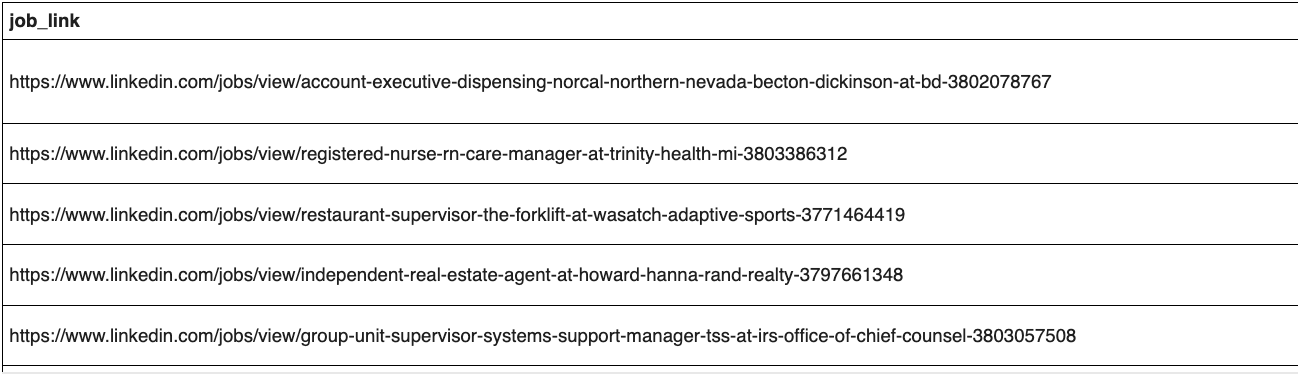

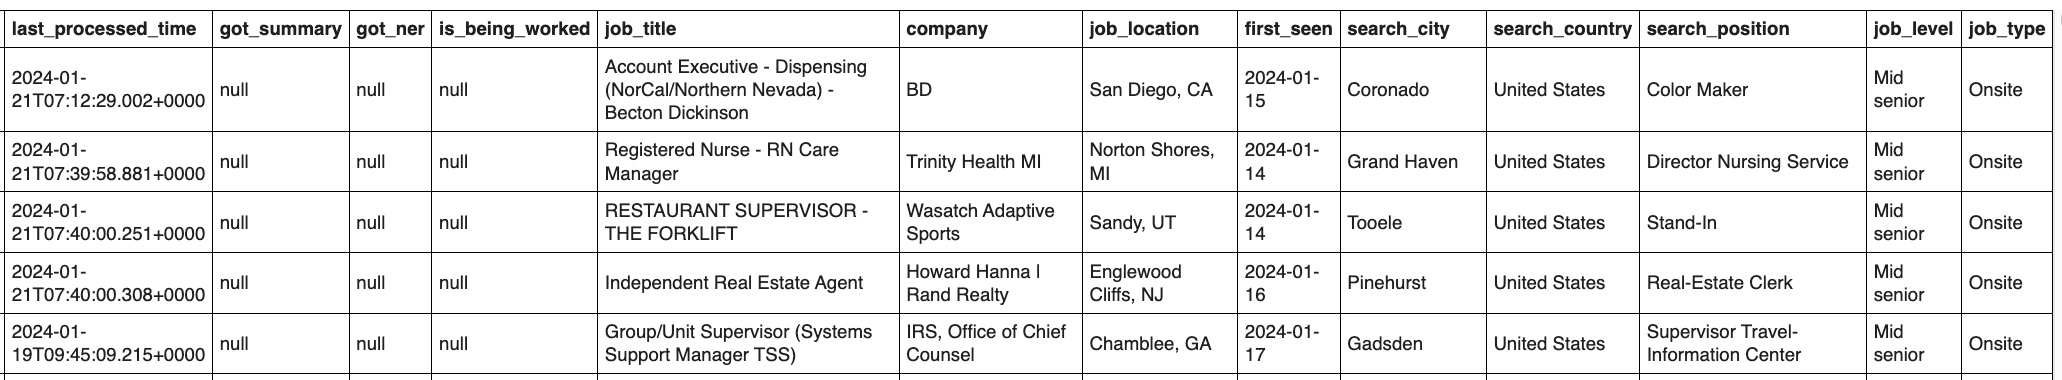

In [ ]:
# Creating view for Linkedin Job posting

temp_table_name = 'job_postings'
job_postings_DF.createOrReplaceTempView(temp_table_name)

In [ ]:
%sql
select count(*) from job_postings where job_link like 'https%'

count(1)
1348454


In [ ]:

%sql
-- creating permanent table for job_postings
create or replace table job_postings_1 as
select * from job_postings

num_affected_rows,num_inserted_rows


##### **loading Job Skills table** -

We observed that infer_schema worked correctly on the job_skills dataset. The schema method used in job_postings also worked. so we decided to use the former.

In [ ]:
from pyspark.sql.types import StructType, StringType, StructField

# Loading job skills data
file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/job_skills.csv"
file_type = "csv"

infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

job_skills_DF = spark.read.format(file_type) \
    .option("inferSchema", infer_schema) \
    .option("header", first_row_is_header) \
    .option("sep", delimiter) \
    .load(file_location)

# Show the inferred schema
job_skills_DF.printSchema()

# Display the DataFrame
display(job_skills_DF)


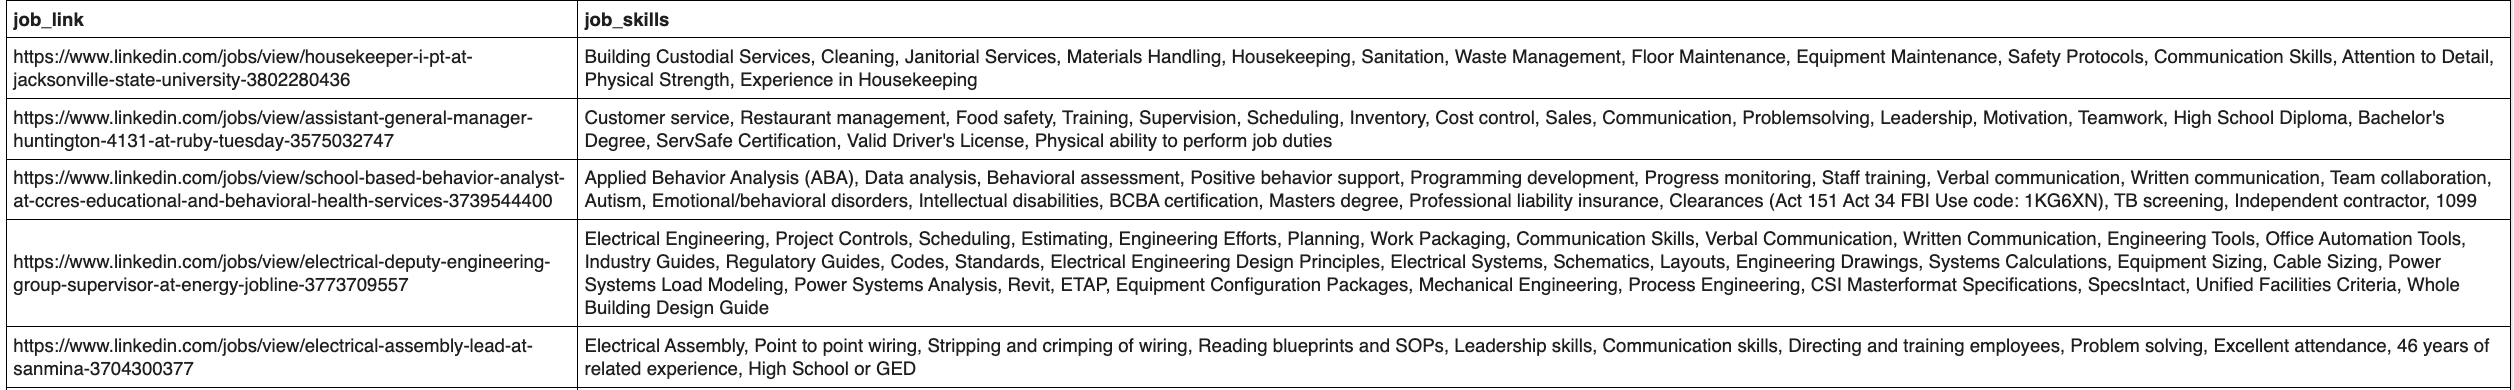

In [ ]:
# Creating view for Linkedin skills
temp_table_name = 'job_skills'
job_skills_DF.createOrReplaceTempView(temp_table_name)

In [ ]:

%sql
-- creating permanent table for job_skills
create or replace table job_skills_1 as
select * from job_skills

num_affected_rows,num_inserted_rows


In [ ]:
%sql

select count(*) from job_skills;-- where job_link like 'https%';

count(1)
1296381


##### **challenges in loading job_summary**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import re

# Loading job skills data
file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_1_200000.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","  # Since each column is wrapped with double quotes

# The applied options are for CSV files. For other file types, these will be ignored.
lisum1test = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option("encoding", "UTF-8") \
  .option("multiLine", "true") \
  .load(file_location)


In [ ]:
sc = spark.sparkContext

path = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_1_200000.csv"

df = spark.read.csv(path)
df.show()

+--------------------+--------------------+
|                 _c0|                 _c1|
+--------------------+--------------------+
|            job_link|         job_summary|
|https://www.linke...|Rock N Roll Sushi...|
|As our Restaurant...| you’ll never be ...|
|            We Offer|                null|
|Competitive compe...|                null|
|  Insurance benefits|                null|
| Bonus opportunities|                null|
|A great work atmo...|                null|
|Duties/Responsibi...|                null|
|Ensuring that our...|                null|
|Maintaining opera...|                null|
|Ensuring that all...|         regulations|
|Creating a restau...|                null|
|Various other tas...|                null|
|        Requirements|                null|
|Previous experien...|                null|
|Extensive food an...| and the ability ...|
|Great leadership ...|                null|
|Familiarity with ...|                null|
|Demonstrated abil...|          

In [ ]:
temp_table_name = 'lisum1test'
lisum1test.createOrReplaceTempView(temp_table_name)

In [ ]:
%sql

select * from lisum1test where job_link not like 'https%'

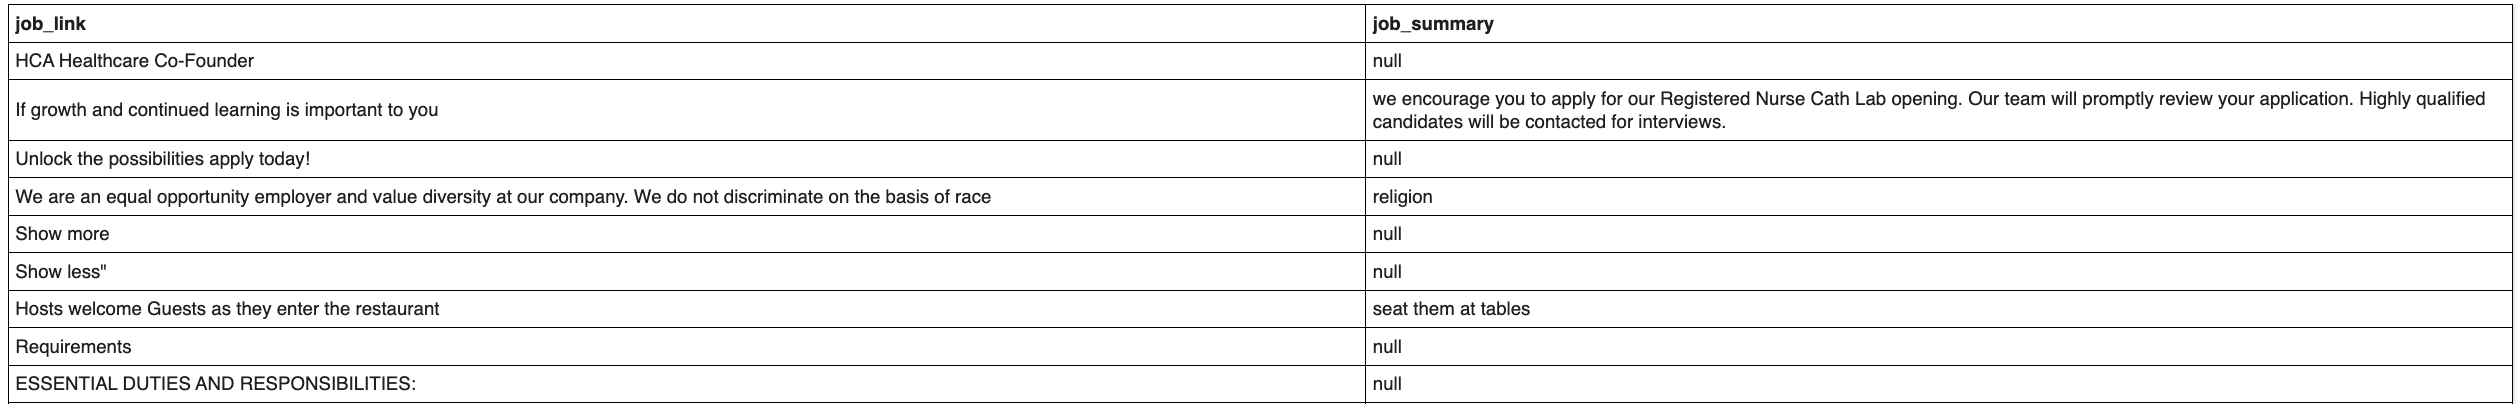

We can see that some of the job_summary rows are in the job_links columns and vice versa.

##### **Loading Job Summary**

#####  We had faced significant challenges for data loading and data cleaning in the job_summary table. Firstly, the job_summary being a 5.1 GB file we could not load the file into databricks as databricks community edition permits loading of 2GB per file.  so in order to work on the file in databricks we had to break up this file into smaller sections. We also wanted to filter the data to inlcude only those jobs_posting in the US.

##### To achieve this objective we had to use excel, microsoft access, AWS or jupyter notebook. since excel has a limitation of 1.049 mn records, we initially looked at other solutions. As one of us had a paid account on AWS, we tried to work  inital objective was to the load the table in AWS, merge it with job_posting table and export the result of the query , using linux commands on AWS EC2 x-large instance and increasing volume of storage from 30GB to 90GB after realsing that our storage volume had reached 100% capacity and we were not able to access the aws intance we had created.

##### We used the following linux command to do the above:

!xsv join job_link location.csv job_link linkedin_job_postings.csv | \
xsv search -s search_country '^United States$' | \
xsv select job_link,job_summary | \
xsv split -s 200000 outputdir2

##### We decided to split the merged file into records of 200,000 each since 5.1GB/6 = 850 MB per file which would load into databricks and 1.3mn records/6 = 216k records per file. so we rounded this to reach to keep 200,000 recrods per file.

##### However, upon loadng the split file from AWS, we realised that the formatting of the csv file had changed wherein portions of job_summary appeared in job_link. We realised this error was due to the difference in encoding on the original csv file and the output generated on aws.

##### Our next objective was to figure out how to correct the error and export the csv with the correct format.

##### As we reached a roadblock with regard to using AWS, we next tried to use python jupyter notebook to first import the csv as a dataframe and export the dataframe using .to_csv using QUOTE_ALL to separate each row by double quotes and save these into files of 200,000 records each:

df.to_csv("job_summary_v2.csv", index=False, quoting=csv.QUOTE_ALL)

df2 = pd.read_csv('location.csv')
start = 0
end = 1300000
step = 200000

for i in range(start, end, step):
    subset_end = min(i + step, end)               
    subset_name = f"subset_{i+1}-{subset_end}.csv"  
    df_subset = df.iloc[i:subset_end]              
    df_subset.to_csv(subset_name, index=False)    

##### Simulatenously, we had also used excel's Power query function to load the 5.1GB orginal file and split it into 7 files of upto 200,000 rows each. This method proved to be successful in splitting the file keeping to the original encoding.

##### However, while loading the output files from the python .to_csv and excel files we could still see the encoding issue persisting, as some of the 34 rows of the 'job_link' columns were not in the format 'https%' and 6000+ rows of the 'job_summary' were having nulls, while none of the original file had nulls. We had added .option "encoding,'UTF-8'" aswell in order to read the dataset using encoding UTF-8, however this did not work.

##### We realised that the issue could be the method we used to read the csv file into pyspark on databricks. To rectify this,
##### we removed 'inferschema' which automatically identifies schema and added:

  .option("escape", "\"") \
  .option("quote", "\"") \ # as the columns start with and end with quotes
  .option("multiLine", "true") \ # as job_summary had mutiple rows of data separated by a new line

##### Using the files exported from pythons .to_csv function which had quotes on all the columns and rows, we were able to succefully load and read all 12,97,332 million records of job_summary. All rows in job_links had records starting with 'https%' and none of the job_summary columns had nulls.

##### We learnt that careful consideration must be give to how a csv file is read into pyspark especially when dealing with web scraped data.

In [ ]:
# Loading job skills data 1

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_1_200000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum1 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

# Show the inferred schema
lisum1.printSchema()

# Display the DataFrame
display(lisum1)

In [ ]:
# Creating view for Linkedin summary
temp_table_name = 'lisum_1'
lisum1.createOrReplaceTempView(temp_table_name)


In [ ]:
# Loading job skills data 2 -200000

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_200001_400000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum2 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_2'
lisum2.createOrReplaceTempView(temp_table_name)

In [ ]:
# Loading job skills data 3 -200000

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_400001_600000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum3 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_3'
lisum3.createOrReplaceTempView(temp_table_name)

In [ ]:
# Loading job skills data 4 -200000

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_600001_800000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum4 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_4'
lisum4.createOrReplaceTempView(temp_table_name)

In [ ]:
# Loading job skills data 5 -200000

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_800001_1000000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum5 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_5'
lisum5.createOrReplaceTempView(temp_table_name)

In [ ]:
# Loading job skills data 6 -200000

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_1000001_1200000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum6 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_6'
lisum6.createOrReplaceTempView(temp_table_name)

In [ ]:
# Loading job skills data 7 -97332

from pyspark.sql.types import StructType, StringType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/subset_1200001_1300000.csv"
file_type = "csv"

schema = StructType([
  StructField("job_link", StringType(), True),
  StructField("job_summary", StringType(), True)
])

lisum7 = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

temp_table_name = 'lisum_7'
lisum7.createOrReplaceTempView(temp_table_name)

In [ ]:
%sql

select count(*) from lisum_7 where job_summary is not null;
-- like 'https%';

count(1)
97332


In [ ]:
%sql
create or replace table job_summary_all as
select job_link, job_summary from lisum_1
union
select job_link, job_summary from lisum_2
union
select job_link, job_summary from lisum_3
union
select job_link, job_summary from lisum_4
union
select job_link, job_summary from lisum_5
union
select job_link, job_summary from lisum_6
union
select job_link, job_summary from lisum_7;



num_affected_rows,num_inserted_rows


In [ ]:
%sql

select count(*) from job_summary_all;

count(1)
1297332



#### **1.2 Data cleaning**

In [ ]:
%sql
select * from job_postings limit 2

job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
https://www.linkedin.com/jobs/view/account-executive-dispensing-norcal-northern-nevada-becton-dickinson-at-bd-3802078767,2024-01-21T07:12:29.002+0000,null,null,null,Account Executive - Dispensing (NorCal/Northern Nevada) - Becton Dickinson,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
https://www.linkedin.com/jobs/view/registered-nurse-rn-care-manager-at-trinity-health-mi-3803386312,2024-01-21T07:39:58.881+0000,null,null,null,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite


In [ ]:
%sql
select count(*) from job_skills_1 where job_skills is null

count(1)
2007


##### we see 2007 records where the job_skills is null, hence we remove these rows for both columns

In [ ]:
%sql
delete from job_skills_1 where job_skills is null

num_affected_rows
2007


##### For the purpose of this project we remove all companies that contain non-english company names so as to reduce chances of error while merging. We have also deleted rows where 'company' is null or 'company' is solely characters others than letters or digits.

##### we do not see any non-http job_links we assume the dataset is clean and we can perform EDA on the table li_jp_skills.

In [ ]:
%sql
Delete from job_postings_1 where company is null;

num_affected_rows
11


In [ ]:
%sql

Delete FROM job_postings_1
WHERE company IS NOT NULL
AND company REGEXP '^[^a-zA-Z0-9]+$';

num_affected_rows
83


In [ ]:
%sql

select count(*) from job_postings_1 where company = '.';


count(1)
0



##### The 'job_link' column is the primary key in the job_posting and the other two tables 'job_summary' and 'job_skills'.

In [ ]:
%sql

CREATE or replace TABLE jp_skills_summary AS
SELECT
    ROW_NUMBER() OVER(ORDER BY a.job_link) AS row_num,
    a.job_link,
    a.last_processed_time,
    a.got_summary,
    a.got_ner,
    a.is_being_worked,
    a.job_title,
    a.company,
    a.job_location,
    a.first_seen,
    a.search_city,
    a.search_country,
    a.search_position,
    a.job_level,
    a.job_type,
    b.job_skills,
    c.job_summary
FROM
    job_postings_1 a
JOIN
    job_skills_1 b ON a.job_link = b.job_link
JOIN
    job_summary_all c ON a.job_link = c.job_link;
--WHERE     a.job_search = 'United States'

num_affected_rows,num_inserted_rows


##### Next we check if there are any duplicate records for each of the job_links. Ideally, we should see one job_link for each job skill and job_summary.

In [ ]:
%sql

select job_link, count(*) from jp_skills_summary
group by 1
having count(*)> 1

job_link,count(1)


##### To futher validate the job_links field we check if all the job_links are similar and start with 'http%'. We check if there are any job_links that do not start with 'http' in the li_jp_skills table.

In [ ]:
%sql

select count(*) from jp_skills_summary where job_link not like 'http%';

count(1)
0


### **2. Adding and merging existing dataset to an Industry dataset obtained from kaggle**

%md

Since our dataset was missing the industry in which the companies belong to, we decided to merge with a recent dataset that contain 17Mn companies info and industry details we found: https://www.kaggle.com/datasets/mfrye0/bigpicture-company-dataset. This was a 2.1 GB file which we were able to load in Databricks and save the dataset as a dataframe 'industry'.

We wanted to futher understand the dataset based on industry so that our findings were more accurate to job hunters targeting certain industries.

Howerver, there were challenges in merging both the datasets, since:

(1) These datasets were not related to each other or from the same source (i.e. linkedin) so there were no common foreign key.

(2) The only relevant columns in job_postings table was 'company'(company name) and 'job_location'(in the format city,state,country). While the only relevant column in the industry table were 'name' (company name) and 'city','state' and 'country_code'.

(3) As job_location was in the format 'city or province,state,country' in one column , we had to break this into  3 columns - city, state and country. The next challenge in this was the non-uniformity of the job_location column. For Eg. job location had records such as 'Austin,TX','Greater Perth Area' and 'Essex,London,United Kingdom'. While the last one was easy to delimit based on comma, we had to figure out how we could change:

'Austin,TX' -> 'Austin, Texas, United States'
and
'Greater Perth Area' -> 'Greater Perth Area, Western Australia, Australia'.  

There were 28,777 rows of uique job_locations of which 20,000 were in the format 'Austin,TX' and the remaining in 'Greater Perth Area' format and other single name formats.

We decided to work on these manually by exporting the distinct job_locations as csv and manually fill up the state, country where they were missing.
    
To speed up the manuel work we used ChatGTP 3.5 to generate the missing state and country fields for each of the city/province. Of the 20,000 records in the format 'Austin,TX there were 103 unique values, so we created a lookup table of these 103 unique value and used VLOOKUP to complete the 20,000 records.

(4) As industry table did not have a country column and had a 'country_code', we added a column to the table using ALTER TABLE and UPDATE statement to add the country name based on the 'country_code'.

We followed this approch so to keep to orignal structure of the data as much as possible and not manipulate it to the extent that we were changing the location of the company.

Now as we had city,state and country in the both tables we could join both tables on 'city', 'state', 'country' and 'company name'.

We could not merge both datasets solely on one column such as 'city' or 'state' as there were companies in differnt locations with the same name. so joining both tables would give us incorrect data.

Eg. The company 'Gamestop' has 109 locations. So if we do not join on all four criteria, we would not know the job_posting was releated to which exact location and which industry.

Eg. The company 'Atlas' has 3 locations, 'Boston, MA', 'New York, NY' and 'Austin, TX' as these are three separate companies or 3 different branch location. however to see the exact location and industry of the job advertised we have to join on the four columns.




#### **2.0 Loading Industry dataset**

In [ ]:

#Loading Industry dataset

from pyspark.sql.types import StructType, StringType, TimestampType, BooleanType,StructField

file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/companies_2023_q4_sm.csv"
file_type = "csv"

# Define the schema for the DataFrame
schema = StructType([
    StructField("handle", StringType(), True),
    StructField("name", StringType(), True),
    StructField("website", StringType(), True),
    StructField("industry", StringType(), True),
    StructField("size", StringType(), True),
    StructField("type", StringType(), True),
    StructField("founded", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("country_code", StringType(), True),
])

#  .option("inferSchema", infer_schema) \
# The applied options are for CSV files. For other file types, these will be ignored.
industry = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

# Show the inferred schema
industry.printSchema()

# Display the DataFrame
display(industry)

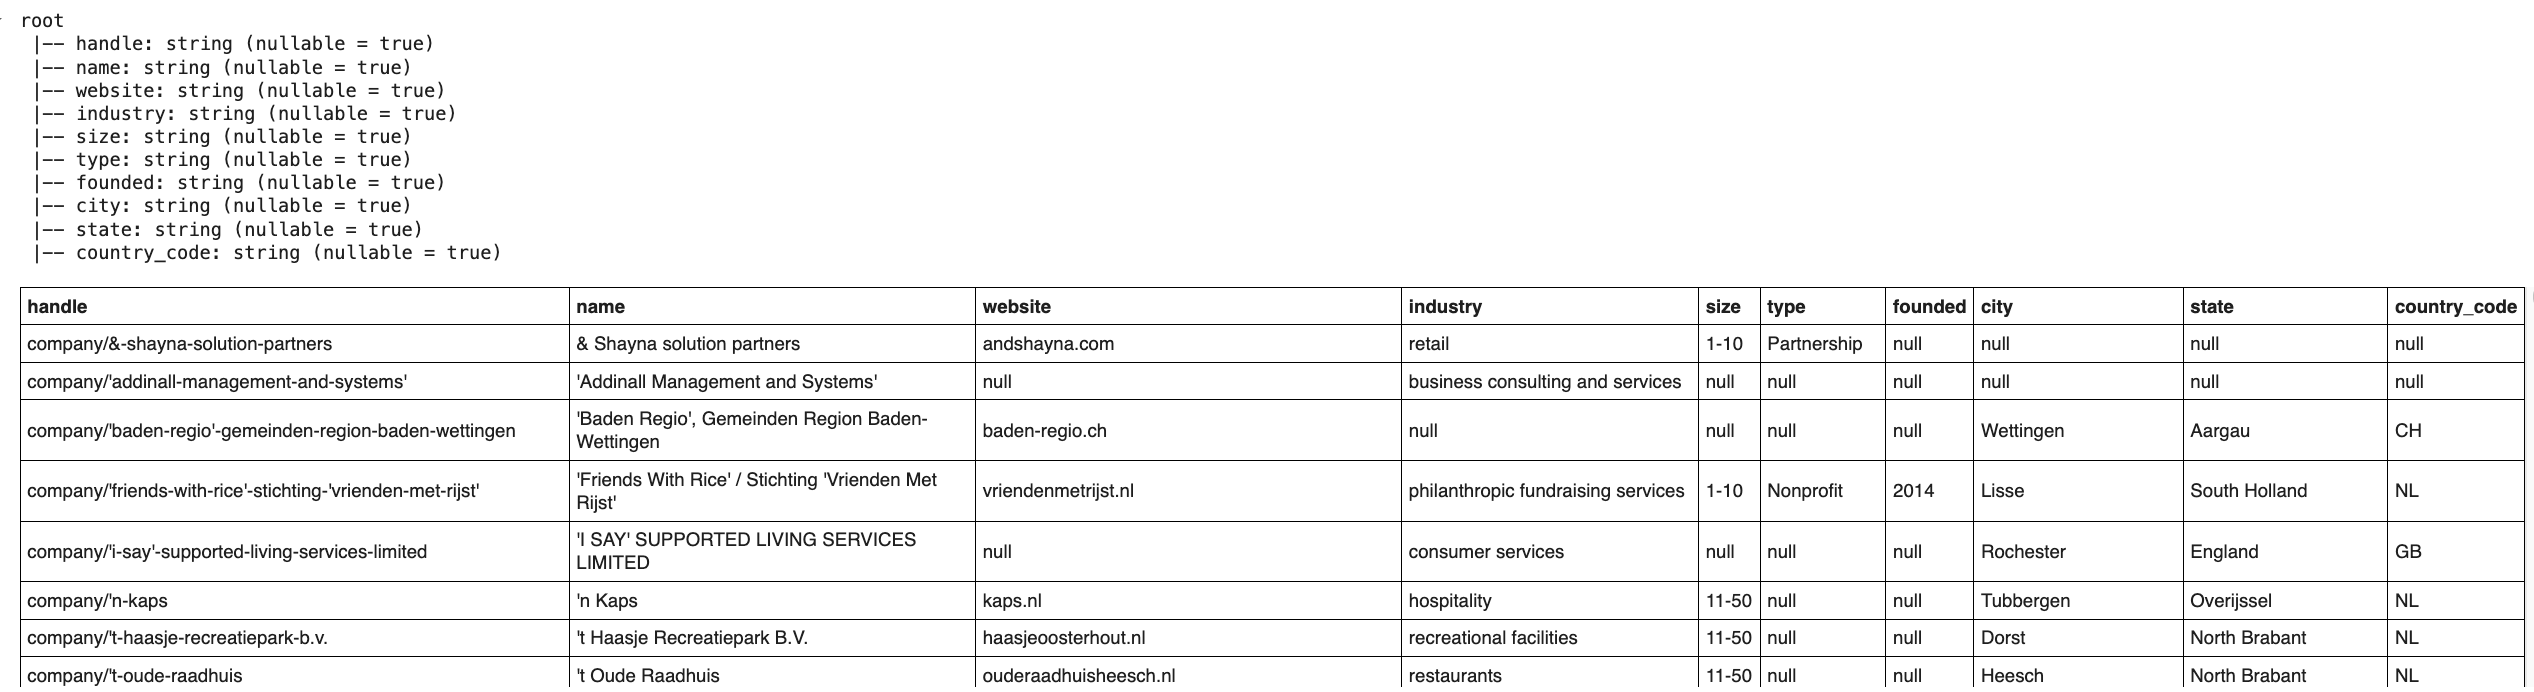

In [ ]:
# Creating view for industry
industry.createOrReplaceTempView('industry')

#### **2.1 Adding revised 'job_location' csv file which has job_location column separated into 'city', 'state', 'country'**

In [ ]:

#Loading updated job_location table

from pyspark.sql.types import StructType, StringType, TimestampType, BooleanType,StructField,IntegerType
file_location = "dbfs:/FileStore/shared_uploads/jeff.mathewsam@gwmail.gwu.edu/lookup_table_for_our_main_df_city_state_country_breakup.csv"
file_type = "csv"

# Define the schema for the DataFrame
schema = StructType([
    StructField("job_location", StringType(), True),
    StructField("city_province", StringType(), True),
    StructField("state", StringType(), True),
    StructField("country", StringType(), True),
])

#  .option("inferSchema", infer_schema) \
# The applied options are for CSV files. For other file types, these will be ignored.
job_loc = spark.read.format(file_type) \
  .option("header", "true") \
  .option("sep", ",") \
  .option("escape", "\"") \
  .option("quote", "\"") \
  .option("multiLine", "true") \
  .schema(schema) \
  .load(file_location)

# Show the inferred schema
job_loc.printSchema()

# Display the DataFrame
display(job_loc)


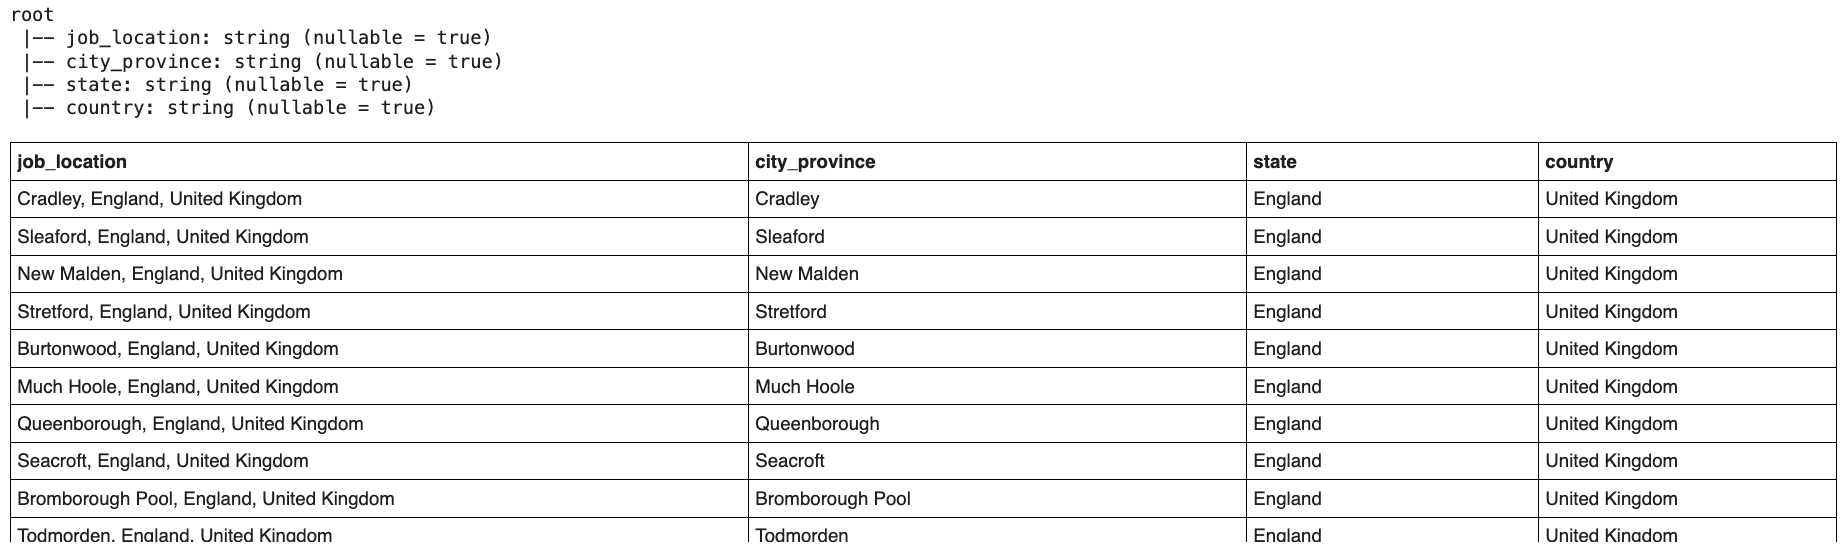

In [ ]:
job_loc.createOrReplaceTempView('job_loc')

In [ ]:
%sql
create or replace table job_loc_new as
select * from job_loc;

num_affected_rows,num_inserted_rows


#### **2.2 Joined table 'jp_skills_summary_new' with city_province, state, country to create 'jp_skills_summary_new'**

In [ ]:
%sql
create or replace table jp_skills_summary_new as
select distinct a.*, b.city_province,b.state,b.country
from jp_skills_summary a
inner join job_loc b on a.job_location = b.job_location;

num_affected_rows,num_inserted_rows


In [ ]:
%sql

select job_link, count(*) from jp_skills_summary_new
group by 1 having count(*) > 1 limit 10

job_link,count(1)


#### **2.3 Adding new column country to be used in place of 'country_code' in 'Industry' table**

In [ ]:
%sql
create or replace table industry_new as
select * from industry;

num_affected_rows,num_inserted_rows



###### Cleaning Industry table

We delete all rows where company 'name' is null or contains characters other than letters or digits. For the purpose of this project we remove all non-english company names. We remove these since joining two tables where the company name is null is menaingless when trying to obtain the indstry detail.

In [ ]:
%sql
Delete from industry_new where name is null;

num_affected_rows
4683


In [ ]:
%sql

Delete FROM industry_new
WHERE name IS NOT NULL
AND name REGEXP '^[^a-zA-Z0-9]+$';

num_affected_rows
119244


In [ ]:
%sql
ALTER TABLE industry_new ADD COLUMN Country VARCHAR(100);
UPDATE industry_new
SET Country = CASE country_code
    WHEN 'LT' THEN 'Lithuania'
    WHEN 'DZ' THEN 'Algeria'
    WHEN 'MM' THEN 'Myanmar'
    WHEN 'CI' THEN 'Ivory Coast'
    WHEN 'TC' THEN 'Turks and Caicos Islands'
    WHEN 'FI' THEN 'Finland'
    WHEN 'SC' THEN 'Seychelles'
    WHEN 'AZ' THEN 'Azerbaijan'
    WHEN 'PM' THEN 'Saint Pierre and Miquelon'
    WHEN 'UA' THEN 'Ukraine'
    WHEN 'RO' THEN 'Romania'
    WHEN 'ZM' THEN 'Zambia'
    WHEN 'KI' THEN 'Kiribati'
    WHEN 'SL' THEN 'Sierra Leone'
    WHEN 'JOR' THEN 'Jordan'
    WHEN 'NL' THEN 'Netherlands'
    WHEN 'LA' THEN 'Laos'
    WHEN 'SB' THEN 'Solomon Islands'
    WHEN 'BW' THEN 'Botswana'
    WHEN 'BS' THEN 'Bahamas'
    WHEN 'MN' THEN 'Mongolia'
    WHEN 'PL' THEN 'Poland'
    WHEN 'AM' THEN 'Armenia'
    WHEN 'RE' THEN 'Réunion'
    WHEN 'PS' THEN 'Palestine'
    WHEN 'MK' THEN 'North Macedonia'
    WHEN 'MX' THEN 'Mexico'
    WHEN 'PF' THEN 'French Polynesia'
    WHEN 'GL' THEN 'Greenland'
    WHEN 'EE' THEN 'Estonia'
    WHEN 'VG' THEN 'British Virgin Islands'
    WHEN 'SM' THEN 'San Marino'
    WHEN 'CN' THEN 'China'
    WHEN 'UM' THEN 'United States Minor Outlying Islands'
    WHEN 'AT' THEN 'Austria'
    WHEN 'RU' THEN 'Russia'
    WHEN 'IQ' THEN 'Iraq'
    WHEN 'NA' THEN 'Namibia'
    WHEN 'SJ' THEN 'Svalbard and Jan Mayen'
    WHEN 'CG' THEN 'Republic of the Congo'
    WHEN 'AD' THEN 'Andorra'
    WHEN 'HR' THEN 'Croatia'
    WHEN 'SV' THEN 'El Salvador'
    WHEN 'LI' THEN 'Liechtenstein'
    WHEN 'null' THEN NULL
    WHEN 'CZ' THEN 'Czech Republic'
    WHEN 'NP' THEN 'Nepal'
    WHEN 'VA' THEN 'Vatican City'
    WHEN 'PT' THEN 'Portugal'
    WHEN 'SO' THEN 'Somalia'
    WHEN 'PG' THEN 'Papua New Guinea'
    WHEN 'GG' THEN 'Guernsey'
    WHEN 'CX' THEN 'Christmas Island'
    WHEN 'KY' THEN 'Cayman Islands'
    WHEN 'GH' THEN 'Ghana'
    WHEN 'HK' THEN 'Hong Kong'
    WHEN 'BN' THEN 'Brunei'
    WHEN 'CV' THEN 'Cape Verde'
    WHEN 'LR' THEN 'Liberia'
    WHEN 'TW' THEN 'Taiwan'
    WHEN 'AZE' THEN 'Azerbaijan'
    WHEN 'BD' THEN 'Bangladesh'
    WHEN 'LB' THEN 'Lebanon'
    WHEN 'PY' THEN 'Paraguay'
    WHEN 'MLT' THEN 'Malta'
    WHEN 'CL' THEN 'Chile'
    WHEN 'TO' THEN 'Tonga'
    WHEN 'ID' THEN 'Indonesia'
    WHEN 'LY' THEN 'Libya'
    WHEN 'FK' THEN 'Falkland Islands'
    WHEN 'BGD' THEN 'Bangladesh'
    WHEN 'AU' THEN 'Australia'
    WHEN 'PK' THEN 'Pakistan'
    WHEN 'SA' THEN 'Saudi Arabia'
    WHEN 'CA' THEN 'Canada'
    WHEN 'MW' THEN 'Malawi'
    WHEN 'BM' THEN 'Bermuda'
    WHEN 'BL' THEN 'Saint Barthélemy'
    WHEN 'NE' THEN 'Niger'
    WHEN 'UZ' THEN 'Uzbekistan'
    WHEN 'GB' THEN 'United Kingdom'
    WHEN 'MT' THEN 'Malta'
    WHEN 'YE' THEN 'Yemen'
    WHEN 'BLR' THEN 'Belarus'
    WHEN 'MNG' THEN 'Mongolia'
    WHEN 'BR' THEN 'Brazil'
    WHEN 'KZ' THEN 'Kazakhstan'
    WHEN 'BY' THEN 'Belarus'
    WHEN 'HN' THEN 'Honduras'
    WHEN 'NC' THEN 'New Caledonia'
    WHEN 'GT' THEN 'Guatemala'
    WHEN 'MD' THEN 'Moldova'
    WHEN 'DE' THEN 'Germany'
    WHEN 'AW' THEN 'Aruba'
    WHEN 'GN' THEN 'Guinea'
    WHEN 'IO' THEN 'British Indian Ocean Territory'
    WHEN 'NOR' THEN 'Norway'
    WHEN 'IR' THEN 'Iran'
    WHEN 'ES' THEN 'Spain'
    WHEN 'EC' THEN 'Ecuador'
    WHEN 'BH' THEN 'Bahrain'
    WHEN 'MO' THEN 'Macau'
    WHEN 'NR' THEN 'Nauru'
    WHEN 'VI' THEN 'U.S. Virgin Islands'
    WHEN 'TUV' THEN 'Tuvalu'
    WHEN 'IL' THEN 'Israel'
    WHEN 'TR' THEN 'Turkey'
    WHEN 'ME' THEN 'Montenegro'
    WHEN 'VE' THEN 'Venezuela'
    WHEN 'MR' THEN 'Mauritania'
    WHEN 'ZA' THEN 'South Africa'
    WHEN 'CR' THEN 'Costa Rica'
    WHEN 'AI' THEN 'Anguilla'
    WHEN 'SX' THEN 'Sint Maarten'
    WHEN 'GU' THEN 'Guam'
    WHEN 'KR' THEN 'South Korea'
    WHEN 'TZ' THEN 'Tanzania'
    WHEN 'US' THEN 'United States'
    WHEN 'RS' THEN 'Serbia'
    WHEN 'AQ' THEN 'Antarctica'
    WHEN 'MS' THEN 'Montserrat'
    WHEN 'AL' THEN 'Albania'
    WHEN 'MY' THEN 'Malaysia'
    WHEN 'IN' THEN 'India'
    WHEN 'JM' THEN 'Jamaica'
    WHEN 'CK' THEN 'Cook Islands'
    WHEN 'LC' THEN 'Saint Lucia'
    WHEN 'GM' THEN 'Gambia'
    WHEN 'AND' THEN 'Andorra'
    WHEN 'PER' THEN 'Peru'
    WHEN 'AE' THEN 'United Arab Emirates'
    WHEN 'MQ' THEN 'Martinique'
    WHEN 'CM' THEN 'Cameroon'
    WHEN 'RW' THEN 'Rwanda'
    WHEN 'TG' THEN 'Togo'
    WHEN 'FR' THEN 'France'
    WHEN 'CYM' THEN 'Cayman Islands'
    WHEN 'GF' THEN 'French Guiana'
    WHEN 'CH' THEN 'Switzerland'
    WHEN 'MG' THEN 'Madagascar'
    WHEN 'CC' THEN 'Cocos (Keeling) Islands'
    WHEN 'TN' THEN 'Tunisia'
    WHEN 'MNE' THEN 'Montenegro'
    WHEN 'GQ' THEN 'Equatorial Guinea'
    WHEN 'USA' THEN 'United States'
    WHEN 'NU' THEN 'Niue'
    WHEN 'TL' THEN 'Timor-Leste'
    WHEN 'WF' THEN 'Wallis and Futuna'
    WHEN 'MAR' THEN 'Morocco'
    WHEN 'GEO' THEN 'Georgia'
    WHEN 'GR' THEN 'Greece'
    WHEN 'PA' THEN 'Panama'
    WHEN 'TD' THEN 'Chad'
    WHEN 'GI' THEN 'Gibraltar'
    WHEN 'SD' THEN 'Sudan'
    WHEN 'PAN' THEN 'Panama'
    WHEN 'AG' THEN 'Antigua and Barbuda'
    WHEN 'MC' THEN 'Monaco'
    WHEN 'DJ' THEN 'Djibouti'
    WHEN 'JO' THEN 'Jordan'
    WHEN 'BA' THEN 'Bosnia and Herzegovina'
    WHEN 'ET' THEN 'Ethiopia'
    WHEN 'SG' THEN 'Singapore'
    WHEN 'KP' THEN 'North Korea'
    WHEN 'BF' THEN 'Burkina Faso'
    WHEN 'IT' THEN 'Italy'
    WHEN 'CU' THEN 'Cuba'
    WHEN 'GW' THEN 'Guinea-Bissau'
    WHEN 'MV' THEN 'Maldives'
    WHEN 'FO' THEN 'Faroe Islands'
    WHEN 'ISR' THEN 'Israel'
    WHEN 'SE' THEN 'Sweden'
    WHEN 'PH' THEN 'Philippines'
    WHEN 'BG' THEN 'Bulgaria'
    WHEN 'WS' THEN 'Samoa'
    WHEN 'FJ' THEN 'Fiji'
    WHEN 'GE' THEN 'Georgia'
    WHEN 'SK' THEN 'Slovakia'
    WHEN 'FM' THEN 'Micronesia'
    WHEN 'CW' THEN 'Curaçao'
    WHEN 'MH' THEN 'Marshall Islands'
    WHEN 'PE' THEN 'Peru'
    WHEN 'LV' THEN 'Latvia'
    WHEN 'MU' THEN 'Mauritius'
    WHEN 'LS' THEN 'Lesotho'
    WHEN 'MZ' THEN 'Mozambique'
    WHEN 'GD' THEN 'Grenada'
    WHEN 'MAC' THEN 'Macau'
    WHEN 'KM' THEN 'Comoros'
    WHEN 'DM' THEN 'Dominica'
    WHEN 'DO' THEN 'Dominican Republic'
    WHEN 'QA' THEN 'Qatar'
    WHEN 'BZ' THEN 'Belize'
    WHEN 'CAN' THEN 'Canada'
    WHEN 'XK' THEN 'Kosovo'
    WHEN 'TH' THEN 'Thailand'
    WHEN 'EG' THEN 'Egypt'
    WHEN 'BI' THEN 'Burundi'
    WHEN 'SH' THEN 'Saint Helena, Ascension and Tristan da Cunha'
    WHEN 'COL' THEN 'Colombia'
    WHEN 'BJ' THEN 'Benin'
    WHEN 'MF' THEN 'Saint Martin'
    WHEN 'GY' THEN 'Guyana'
    WHEN 'JP' THEN 'Japan'
    WHEN 'TM' THEN 'Turkmenistan'
    WHEN 'VC' THEN 'Saint Vincent and the Grenadines'
    WHEN 'ZW' THEN 'Zimbabwe'
    WHEN 'SN' THEN 'Senegal'
    WHEN 'NZ' THEN 'New Zealand'
    WHEN 'KEN' THEN 'Kenya'
    WHEN 'LK' THEN 'Sri Lanka'
    WHEN 'OM' THEN 'Oman'
    WHEN 'BT' THEN 'Bhutan'
    WHEN 'HU' THEN 'Hungary'
    WHEN 'KN' THEN 'Saint Kitts and Nevis'
    WHEN 'KE' THEN 'Kenya'
    WHEN 'CY' THEN 'Cyprus'
    WHEN 'SI' THEN 'Slovenia'
    WHEN 'ML' THEN 'Mali'
    WHEN 'GP' THEN 'Guadeloupe'
    WHEN 'HT' THEN 'Haiti'
    WHEN 'UG' THEN 'Uganda'
    WHEN 'IE' THEN 'Ireland'
    WHEN 'KW' THEN 'Kuwait'
    WHEN 'GA' THEN 'Gabon'
    WHEN 'VU' THEN 'Vanuatu'
    WHEN 'MA' THEN 'Morocco'
    WHEN 'BE' THEN 'Belgium'
    WHEN 'AS' THEN 'American Samoa'
    WHEN 'KH' THEN 'Cambodia'
    WHEN 'NI' THEN 'Nicaragua'
    WHEN 'KG' THEN 'Kyrgyzstan'
    WHEN 'TT' THEN 'Trinidad and Tobago'
    WHEN 'SXM' THEN 'Sint Maarten'
    WHEN 'NO' THEN 'Norway'
    WHEN 'BO' THEN 'Bolivia'
    WHEN 'SY' THEN 'Syria'
    WHEN 'ER' THEN 'Eritrea'
    WHEN 'CO' THEN 'Colombia'
    WHEN 'IM' THEN 'Isle of Man'
    WHEN 'IND' THEN 'India'
    WHEN 'UY' THEN 'Uruguay'
    WHEN 'SS' THEN 'South Sudan'
    WHEN 'NG' THEN 'Nigeria'
    WHEN 'TF' THEN 'French Southern and Antarctic Lands'
    WHEN 'YT' THEN 'Mayotte'
    WHEN 'JE' THEN 'Jersey'
    WHEN 'MKD' THEN 'North Macedonia'
    WHEN 'AR' THEN 'Argentina'
    WHEN 'CF' THEN 'Central African Republic'
    WHEN 'PW' THEN 'Palau'
    WHEN 'MDA' THEN 'Moldova'
    WHEN 'PR' THEN 'Puerto Rico'
    WHEN 'TK' THEN 'Tokelau'
    WHEN 'LU' THEN 'Luxembourg'
    WHEN 'SZ' THEN 'Eswatini'
    WHEN 'NF' THEN 'Norfolk Island'
    WHEN 'VN' THEN 'Vietnam'
    WHEN 'EH' THEN 'Western Sahara'
    WHEN 'IS' THEN 'Iceland'
    WHEN 'MP' THEN 'Northern Mariana Islands'
    WHEN 'AF' THEN 'Afghanistan'
    WHEN 'SRB' THEN 'Serbia'
    WHEN 'BB' THEN 'Barbados'
    WHEN 'BQ' THEN 'Caribbean Netherlands'
    WHEN 'SR' THEN 'Suriname'
    WHEN 'CHE' THEN 'Switzerland'
    WHEN 'DK' THEN 'Denmark'
    WHEN 'CD' THEN 'Democratic Republic of the Congo'
    WHEN 'TJ' THEN 'Tajikistan'
    WHEN 'AO' THEN 'Angola'
    WHEN 'AX' THEN 'Åland Islands'
    WHEN 'ST' THEN 'São Tomé and Príncipe'
    ELSE NULL
END;

num_affected_rows
17030090


#### **2.4 Joining 'jp_skills_summary_new' and 'industry_new' to create new table that has industry details**

In [ ]:
%sql

create or replace table jp_skills_summary_1 as
select distinct
row_num,
job_link,
--last_processed_time,
--got_summary,
--got_ner,
--is_being_worked,
job_title,
company,
job_location,
a.city_province,a.state, a.country, --from jp_skills_summary_1
first_seen,
search_city,
search_country,
search_position,
job_level,
job_type,
job_skills,
job_summary,
industry
from jp_skills_summary_new a
inner join industry_new b
on
trim(lower(a.company)) = trim(lower(b.name))
and trim(lower(a.country)) = trim(lower(b.country))
and trim(lower(a.state)) = trim(lower(b.state))
and trim(lower(a.city_province)) = trim(lower(b.city));

---trying with joining on company ,state, country


num_affected_rows,num_inserted_rows


In [ ]:
%sql

select count_all, count(job_link)
from(

SELECT job_link,count(*)count_all from jp_skills_summary_1 group by 1 having count(*) > 1
)a group by 1


count_all,count(job_link)
3,386
2,1541
4,3


In [ ]:
%sql

select * from jp_skills_summary_1
where job_link = 'https://www.linkedin.com/jobs/view/staff-firmware-engineer-at-gradient-3794635874'

row_num,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,city_province,state,country,first_seen,search_city,search_country,search_position,job_level,job_type,job_skills,job_summary,industry
1148640,https://www.linkedin.com/jobs/view/staff-firmware-engineer-at-gradient-3794635874,2024-01-19T14:04:54.286+0000,null,null,null,Staff Firmware Engineer,Gradient,"San Francisco, CA",San Francisco,California,United States,2024-01-14,Richmond,United States,Computer Operator,Mid senior,Onsite,"Embedded C, Firmware development, RTOS, Bare metal applications, UART, SPI, I2C, JTAG, AWS IoT Core, IoT consumer products, Wireless communication SoCs, WiFi, BLE, Altium, ECAD, Python, Automation languages, Computer Engineering, Computer Science, Schematics","We are looking for a Staff Firmware Engineer to join our team who is an enthusiastic developer, likes to solve meaningful problems, and can support overall software, backend, controls, & electronics strategy. The ideal candidate is very adaptable and technically minded while having an uncompromising focus and vision for our customer’s needs. An estimated starting salary for this role is $190,000. Responsibilities: Lead and own the design of our firmware architecture. Lead and participate cross-functionally with the business and product teams to define the requirements for our product roadmap. Contribute and collaborate to design and develop all our embedded software systems. Implement energy efficient heating/cooling system control algorithms. Develop User Interfaces that provide a premium user experience across the device and the mobile application. Investigate and implement wireless communication protocols including MQTT, BACnet and Matter. Build systems and processes for continuous deployment, testing, and manufacturing test improvements. Mentor other developers on the team, and create guidelines for best practices to follow. Desired Qualifications: Expert in Embedded C. Firmware development experience in production environments. Computer Engineering/Computer Science degree or equivalent with 7+ years of experience. Proficiency designing RTOS based and bare metal applications.. Expert in communication protocols such as UART, SPI, and I2C. Excellent debugging skills and familiarity with common debugging tools such as JTAG. Proven track record of shipping high-quality electronics and software in consumer products on a tight schedule. Proficiency reading and interpreting schematics. Proficient in Python and other automation languages. Bonus Qualifications Experience with AWS IoT Core and related services. Experience shipping 1 or more IoT consumer products. Experience working with wireless communication SoCs, especially for WiFi and BLE. Experience with Altium or similar ECAD software Benefits Equity Medical/vision/dental/life/disability insurance 401k Paid parental leave Commuter benefits Unlimited PTO within reason Relocation package ( out of state applicants only ) We are committed to building a diverse and inclusive company. We seek to create a culture where everyone can belong because we believe that people do their best work when they can show up every day as their authentic selves. We welcome people of different backgrounds, experiences, abilities, and perspectives. Gradient is an equal opportunity employer. We do not make hiring or employment decisions on the basis of race, religion, color, national origin, gender, gender identity, sexual orientation, age, marital status, veteran status, disability status, or genetic information, in compliance with applicable federal, state and local law. Show more Show less",manufacturing
1148640,https://www.linkedin.com/jobs/view/staff-firmware-engineer-at-gradient-3794635874,2024-01-19T14:04:54.286+0000,null,null,null,Staff Firmware Engineer,Gradient,"San Francisco, CA",San Francisco,California,United States,2024-01-14,Richmond,United States,Computer Operator,Mid senior,Onsite,"Embedded C, Firmware deve

In [ ]:
%sql

create or replace table jms_companies_to_remove as
SELECT job_link,count(*)count_all from jp_skills_summary_1 group by 1 having count(*) > 1;

num_affected_rows,num_inserted_rows


#### **2.5 Deleting 2000 unique job postings which have duplicate industries due to same company names in multiple industries**

In [ ]:
%sql

delete from jp_skills_summary_1 where job_link in (select job_link from jms_companies_to_remove)

num_affected_rows
4252


##### jp_skills_summary_1 will have only records where the country and industry information is available. hence only 185197 records

##### jp_skills_summary_new will have 1.2mn records where we use 'job_location' to find country details but no industry details

### **3. Summary stats of the the 3 tables - job_postings, job_skills, job_summary**

In [ ]:
%sql

--select * from jp_skills_summary_new limit 1;

--job_title

--City used as a search criterion for collecting the job postings.

select distinct job_location,count(job_link) from jp_skills_summary_new group by 1 order by 2 desc


--select job_link, count(*) from jp_skills_summary_1 group by 1 having count(*)> 1 limit 10

--select * from jp_skills_summary_1 where job_link = 'https://www.linkedin.com/jobs/view/staff-firmware-engineer-at-gradient-3794635874'
--industry

--Number of records in table with industry and location breakup: 189449

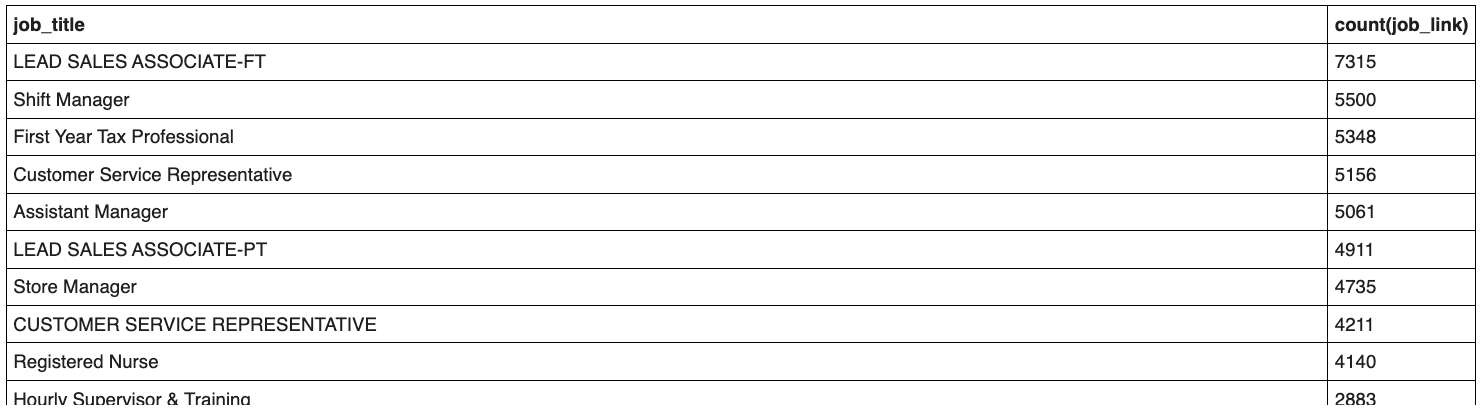

### **4. Identifying which job search keyword and terms to filter from the dataset, that would be useful for our analysis**

##### In order to narrow down on job search keywords we had to decide what terms would job_seekers search for. We decided to focus our analysis on 2 groups of job_seeker: no-experience/less-expereinced undergraduates and graduates, and experienced professionals.

##### 1) **First** we tried to use the keywords we knew and assumed job seekers might look for and checked the count of the job titles with it. we decided to create two subsets: one for the less-experineced/ no-experience undergrads and another query for experienced professionals.

In [ ]:
%sql

select
case when
trim(lower(job_title)) like '%analyst'
or trim(lower(job_title)) like 'analyst%'
or trim(lower(job_title)) like '%analyst%' then 'Analyst'

when trim(lower(job_title)) like '%specialist'
or trim(lower(job_title)) like 'specialist%'
or trim(lower(job_title)) like '%specialist%' then 'Specialist'

when trim(lower(job_title)) like '%data'
or trim(lower(job_title)) like 'data%'
or trim(lower(job_title)) like '%data%' then 'Data'

when trim(lower(job_title)) like '%intern'
or trim(lower(job_title)) like 'intern%'
or trim(lower(job_title)) like '%intern%' then 'Intern'

when trim(lower(job_title)) like '%analysis'
or trim(lower(job_title)) like 'analysis%'
or trim(lower(job_title)) like '%analysis%' then 'Analysis'

when trim(lower(job_title)) like '%junior'
or trim(lower(job_title)) like 'junior%'
or trim(lower(job_title)) like '%junior%' then 'Junior'
else 'other' end as job_title_keyword

,count(job_title)count_title

from jp_skills_summary_1

where
trim(lower(job_title)) like '%analyst'
or trim(lower(job_title)) like 'analyst%'
or trim(lower(job_title)) like '%analyst%'

or trim(lower(job_title)) like '%specialist'
or trim(lower(job_title)) like 'specialist%'
or trim(lower(job_title)) like '%specialist%'

or trim(lower(job_title)) like '%data'
or trim(lower(job_title)) like 'data%'
or trim(lower(job_title)) like '%data%'

or trim(lower(job_title)) like '%intern'
or trim(lower(job_title)) like 'intern%'
or trim(lower(job_title)) like '%intern%'

or trim(lower(job_title)) like '%analysis'
or trim(lower(job_title)) like 'analysis%'
or trim(lower(job_title)) like '%analysis%'

or trim(lower(job_title)) like '%junior'
or trim(lower(job_title)) like 'junior%'
or trim(lower(job_title)) like '%junior%'
group by 1
order by 2 desc;

job_title_keyword,count_title
Analyst,8435
Specialist,6521
Intern,1718
Data,1328
Junior,243
Analysis,242


In [ ]:
%sql
--checking count for jobs title keywords of experienced professional

select
case
when trim(lower(job_title)) like '%manager'
or trim(lower(job_title)) like 'manager%'
or trim(lower(job_title)) like '%manager%' then 'Manager'

when trim(lower(job_title)) like '%associate'
or trim(lower(job_title)) like 'associate%'
or trim(lower(job_title)) like '%associate%' then 'Associate'

when trim(lower(job_title)) like '%director'
or trim(lower(job_title)) like 'director%'
or trim(lower(job_title)) like '%director%' then 'Director'

when trim(lower(job_title)) like '%management'
or trim(lower(job_title)) like 'management%'
or trim(lower(job_title)) like '%management%' then 'Management'

when trim(lower(job_title)) like '%senior'
or trim(lower(job_title)) like 'senior%'
or trim(lower(job_title)) like '%senior%' then 'Senior'

when trim(lower(job_title)) like '%executive'
or trim(lower(job_title)) like 'executive%'
or trim(lower(job_title)) like '%executive%' then 'Executive'

when trim(lower(job_title)) like '%supervisor'
or trim(lower(job_title)) like 'supervisor%'
or trim(lower(job_title)) like '%supervisor%' then 'Supervisor'
else 'other' end as job_title_keyword
,count(job_title)count_title
from jp_skills_summary_1

where
trim(lower(job_title)) like '%manager'
or trim(lower(job_title)) like 'manager%'
or trim(lower(job_title)) like '%manager%'

or trim(lower(job_title)) like '%associate'
or trim(lower(job_title)) like 'associate%'
or trim(lower(job_title)) like '%associate%'

or trim(lower(job_title)) like '%director'
or trim(lower(job_title)) like 'director%'
or trim(lower(job_title)) like '%director%'

or trim(lower(job_title)) like '%management'
or trim(lower(job_title)) like 'management%'
or trim(lower(job_title)) like '%management%'

or trim(lower(job_title)) like '%senior'
or trim(lower(job_title)) like 'senior%'
or trim(lower(job_title)) like '%senior%'

or trim(lower(job_title)) like '%executive'
or trim(lower(job_title)) like 'executive%'
or trim(lower(job_title)) like '%executive%'

or trim(lower(job_title)) like '%supervisor'
or trim(lower(job_title)) like 'supervisor%'
or trim(lower(job_title)) like '%supervisor%'

group by 1
order by 2 desc ;



job_title_keyword,count_title
Manager,31824
Senior,12891
Supervisor,7547
Associate,4764
Executive,3378
Director,1628
Management,1619



##### **Refining job_title keywords to identify most searched job titles for our 2 groups**

##### We also performed a job_title keyword search analysis by looking for the most common keyword appearing in the job_titles. By continuously refining the list of job title words not relevant to our analysis, we found the most frequently used words in job titles, which would also be terms searched by job seekers.

##### However, **we realised both the methods would bias our analysis*** as we would miss keywords that are searched together for eg. 'business analyst' as opposed to 'analyst'.

In [ ]:

import os
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql import SparkSession

# spark = SparkSession.builder.appName("YourAppName").getOrCreate()
sqlc = SQLContext(spark)

# Read the table into a DataFrame
job_title_keywords = sqlc.sql("SELECT job_title FROM jp_skills_summary_1 where country = 'United States'")

# Show the DataFrame schema
job_title_keywords.printSchema()

# Display the DataFrame
job_title_keywords.show()

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- job_title: string (nullable = true)

+--------------------+
|           job_title|
+--------------------+
|Special Education...|
| Executive Assistant|
|Paraprofessional,...|
|Executive Assista...|
|Transplant and Ce...|
|Assistant Instruc...|
|Cloud System Admi...|
|Nuclear Medicine ...|
|Lecturer, Curricu...|
|Research Associat...|
|Retail Operations...|
|Registered Nurse ...|
|Territory Manager...|
|Adjunct Faculty, ...|
|Advanced Practice...|
|Nurse Manager - I...|
|Academic Services...|
|Manager, Enterpri...|
|Inpatient Psychia...|
|Registered Nurse ...|
+--------------------+
only showing top 20 rows



In [ ]:
from operator import add

# Define the list of stop words
list_stop_words_title = ["\n","a", "an", "the", "to", "in", "for", "of", "is", "RT","rt",'',"i","go","was","one","I", "this", "and", "on", "that", "it", "with", "out","you","we","have","tie","not","my","just","or", "as","our","are","be","will","work","all","your","by","skills","&","ii","/","days"
                         ,"program","time","case","physician","medical","rn","registered","nurse","surgical","Sr.","school","center","staff","medicine","full","professor","instructor","coach","customer","shift","staff","sales","iii","center","full","(rn)","care","lead","teacher","lab","faculty","construction","unit","office","team","per","–","_","prn","nights","bonus",
                         "education","pool","officer","head","accounting","human","ft","hospital","adjunct","safety","tech","technical","practice","product","radiology","emergency","2","department","certified","electrical","resources","sign","design","laboratory","family","attorney","security","principal","engineer,","architect","icu","diem","internal","food","patient","pediatric","advisor","cook","compliance","leader","developer","administrator","oncology","mechanical","clinic","|","ct","chef","nursing","advanced","nurse,","therapist","designer"
]

# getting the top words in the job titles in the US
top_words_title = job_title_keywords.select("job_title").rdd \
    .flatMap(lambda r: r['job_title'].replace('"', '').split(' ')) \
    .map(lambda word: word.lower()) \
    .filter(lambda word: word not in list_stop_words_title and '-' not in word) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(add) \
    .takeOrdered(100, key=lambda pair: -pair[1])

print(top_words_title)

[('manager', 22765), ('senior', 12625), ('assistant', 10141), ('engineer', 8009), ('analyst', 6402), ('supervisor', 5959), ('technologist', 5466), ('specialist', 5313), ('clinical', 3956), ('manager,', 3686), ('project', 3446), ('health', 3435), ('associate', 3396), ('service', 3275), ('coordinator', 3117), ('executive', 3006), ('business', 3001), ('research', 2997), ('sr.', 2997), ('technician', 2921), ('services', 2772), ('account', 2571), ('accountant', 2345), ('operations', 2333), ('counselor', 2134), ('development', 2063), ('software', 1942), ('management', 1866), ('scientist', 1858), ('systems', 1808), ('engineering', 1714), ('representative', 1696), ('financial', 1678), ('quality', 1639), ('general', 1627), ('data', 1518), ('practitioner', 1491), ('director', 1465), ('support', 1451), ('volunteer:', 1446), ('part', 1428), ('marketing', 1409), ('maintenance', 1399), ('sr', 1344), ('consultant', 1299), ('production', 1291), ('administrative', 1270), ('room', 838), ('trainer', 831)


##### **Using n-grams(bigrams) - To address this bias we decided to use n-grams(bigrams) analysis to find  the most frequent occuring pair of words in the job_title. So that we could filter our analysis to include only these pairs of words**.

While the above method is useful to identify frequency of words in title, it does not provide insight of words used together which job seekers may search for.

To navigat this :
1) We create a subset of all job_titles from the **United States**.
2) we tokenised job titles into words and generated word paids from the tokenized titles.
3) We counted the frequency of the most occuring bigrams
4) we created 2 filter list of words we assume job seekers would search for: in-experienced/less experienced UG and graduates, and another for experienced professionals.

5) we used the resutling bigrams to create 2 subsets of jobs for the field of business, IT, technology:
  a) Jobs that in-experienced or less experienced graduates would apply for
  b) Jobs that experienced professionals would apply for

6) we will use the 2 lists from step 5 for job_skill and job_summary analysis

7) running the bigrams on jp_skills_summary i.e all countries including the US shows certain additional bigrams that come up in each:


    **Additional bigrams in filter-1 that came in all countries search: NEED TO ADD IF REQUIRED**
    ('analyst', 'with') : 614
    ('operations', 'analyst') : 452
    ('data', 'engineer') : 447
    ('data', 'center') : 395
    ('intelligence', 'analyst') : 387

    **Additional bigrams in filter-2 that came in all countries search: NEED TO ADD IF REQUIRED**:
    ('assistant', 'manager') : 3613
    ('account', 'executive') : 3446
    ('senior', 'project') : 1514
    ('general', 'manager') : 1487
    ('manager', 'in') : 1476
    ('director', 'of') : 1427
    ('development', 'manager') : 1426
    ('service', 'manager') : 1243


In [ ]:
from collections import Counter
import re

# Convert SQL table to Pandas DataFrame
job_titles_df = sqlContext.sql("SELECT job_title FROM jp_skills_summary_1 WHERE country = 'United States'").toPandas()

#job_titles_df = sqlContext.sql("SELECT distinct job_title FROM jp_skills_summary").toPandas()

# Extract job titles from DataFrame
job_titles = job_titles_df['job_title'].tolist()

# Tokenize job titles into words
tokenized_titles = [re.findall(r'\b\w+\b', title.lower()) for title in job_titles]

# Generate word pairs (bigrams) from tokenized job titles
job_title_bigrams = [zip(title[:-1], title[1:]) for title in tokenized_titles]

# Flatten the list of bigrams
flat_bigrams = [pair for sublist in job_title_bigrams for pair in sublist]

# Count the frequency of each bigram
bigram_counts = Counter(flat_bigrams)

# Display the top 50 most frequent bigrams
top_bigrams = bigram_counts.most_common(50)
print("Top 50 most frequent word pairs in job titles:")
for bigram, count in top_bigrams:
    print(bigram, ":", count)


In [ ]:

# Defining 2 lists of words to filter
words_to_filter_1 = ['business', 'analyst', 'specialist', 'data', 'intern', 'junior', 'analysis','information']

words_to_filter_2 = ['manager', 'senior', 'associate', 'director', 'management','executive','supervisor']

# Filter bigrams that contain any of the words in the filter list
filtered_bigrams_1 = [(bigram, count) for bigram, count in bigram_counts.items() if any(word in bigram for word in words_to_filter_1)]

filtered_bigrams_2 = [(bigram, count) for bigram, count in bigram_counts.items() if any(word in bigram for word in words_to_filter_2)]

# Display the filtered bigrams - 1 along with their counts
print("\nBigrams containing the specified words from filterd_bigrams_1:")
for bigram, count in filtered_bigrams_1:
    print(bigram, ":", count)

# Display the filtered bigrams - 2 along with their counts
print("\nBigrams containing the specified words from filterd_bigrams_2:")
for bigram, count in filtered_bigrams_2:
    print(bigram, ":", count)


In [ ]:
# Sort the filtered bigrams by count in descending order
sorted_filtered_bigrams_1 = sorted(filtered_bigrams_1, key=lambda x: x[1], reverse=True)

sorted_filtered_bigrams_2 = sorted(filtered_bigrams_2, key=lambda x: x[1], reverse=True)

# Display the top filtered bigrams_1 by count in descending order
print("\nTop filtered bigrams_1 by count:")
for bigram, count in sorted_filtered_bigrams_1[:20]:
    print(bigram, ":", count)

# Display the top filtered bigrams_2 by count in descending order
print("\nTop filtered bigrams_2 by count:")
for bigram, count in sorted_filtered_bigrams_2[:20]:
    print(bigram, ":", count)



Top filtered bigrams_1 by count:
('business', 'analyst') : 719
('financial', 'analyst') : 660
('business', 'development') : 451
('systems', 'analyst') : 390
('business', 'partner') : 382
('data', 'analyst') : 378
('research', 'specialist') : 269
('analyst', 'ii') : 264
('information', 'technology') : 249
('analyst', 'i') : 234
('senior', 'analyst') : 224
('business', 'intelligence') : 218
('specialist', 'i') : 210
('support', 'specialist') : 209
('business', 'systems') : 205
('senior', 'data') : 197
('research', 'analyst') : 187
('management', 'analyst') : 186
('analyst', 'iii') : 184
('specialist', 'ii') : 180

Top filtered bigrams_2 by count:
('project', 'manager') : 2140
('case', 'manager') : 1742
('account', 'executive') : 1263
('executive', 'assistant') : 1227
('account', 'manager') : 1095
('nurse', 'manager') : 825
('associate', 'professor') : 817
('program', 'manager') : 770
('senior', 'accountant') : 714
('senior', 'manager') : 710
('director', 'of') : 692
('operations', 'mana

##### Creating **2 subset tables of jobs in the US: for in-experienced gradudates and experienced professionals**

In [ ]:
%sql
create or replace table jms_job_prospects_junior_US as
SELECT distinct
CASE
        WHEN LOWER(job_title) LIKE '%business analyst%'
             OR LOWER(job_title) LIKE '%analyst, business%'
             OR LOWER(job_title) LIKE '%business analyst,%'
             OR LOWER(job_title) LIKE '%analyst/business%'
             OR LOWER(job_title) LIKE '%business/analyst%'
             OR LOWER(job_title) LIKE '%analyst or business%'
        THEN 'Business Analyst'
        WHEN LOWER(job_title) LIKE '%financial analyst%'
             OR LOWER(job_title) LIKE '%analyst, financial%'
             OR LOWER(job_title) LIKE '%financial analyst,%'
             OR LOWER(job_title) LIKE '%analyst/financial%'
             OR LOWER(job_title) LIKE '%financial/analyst%'
             OR LOWER(job_title) LIKE '%analyst or financial%'
        THEN 'Financial Analyst'
        WHEN LOWER(job_title) LIKE '%business development%'
             OR LOWER(job_title) LIKE '%development, business%'
             OR LOWER(job_title) LIKE '%business development,%'
             OR LOWER(job_title) LIKE '%development/business%'
             OR LOWER(job_title) LIKE '%business/development%'
             OR LOWER(job_title) LIKE '%development or business%'
        THEN 'Business Development'
        WHEN LOWER(job_title) LIKE '%systems analyst%'
             OR LOWER(job_title) LIKE '%analyst, systems%'
             OR LOWER(job_title) LIKE '%systems analyst,%'
             OR LOWER(job_title) LIKE '%analyst/systems%'
             OR LOWER(job_title) LIKE '%systems/analyst%'
             OR LOWER(job_title) LIKE '%analyst or systems%'
        THEN 'Systems Analyst'
        WHEN LOWER(job_title) LIKE '%business partner%'
             OR LOWER(job_title) LIKE '%partner, business%'
             OR LOWER(job_title) LIKE '%business partner,%'
             OR LOWER(job_title) LIKE '%partner/business%'
             OR LOWER(job_title) LIKE '%business/partner%'
             OR LOWER(job_title) LIKE '%partner or business%'
        THEN 'Business Partner'
        WHEN LOWER(job_title) LIKE '%data analyst%'
             OR LOWER(job_title) LIKE '%analyst, data%'
             OR LOWER(job_title) LIKE '%data analyst,%'
             OR LOWER(job_title) LIKE '%analyst/data%'
             OR LOWER(job_title) LIKE '%data/analyst%'
             OR LOWER(job_title) LIKE '%analyst or data%'
        THEN 'Data Analyst'
        WHEN LOWER(job_title) LIKE '%research specialist%'
             OR LOWER(job_title) LIKE '%specialist, research%'
             OR LOWER(job_title) LIKE '%research specialist,%'
             OR LOWER(job_title) LIKE '%specialist/research%'
             OR LOWER(job_title) LIKE '%research/specialist%'
             OR LOWER(job_title) LIKE '%specialist or research%'
        THEN 'Research Specialist'
        WHEN LOWER(job_title) LIKE '%information technology%'
             OR LOWER(job_title) LIKE '%technology, information%'
             OR LOWER(job_title) LIKE '%information technology,%'
             OR LOWER(job_title) LIKE '%technology/information%'
             OR LOWER(job_title) LIKE '%information/technology%'
             OR LOWER(job_title) LIKE '%technology or information%'
        THEN 'Information Technology'
        WHEN LOWER(job_title) LIKE '%senior analyst%'
             OR LOWER(job_title) LIKE '%analyst, senior%'
             OR LOWER(job_title) LIKE '%senior analyst,%'
             OR LOWER(job_title) LIKE '%analyst/senior%'
             OR LOWER(job_title) LIKE '%senior/analyst%'
             OR LOWER(job_title) LIKE '%analyst or senior%'
        THEN 'Senior Analyst'
        WHEN LOWER(job_title) LIKE '%business intelligence%'
             OR LOWER(job_title) LIKE '%intelligence, business%'
             OR LOWER(job_title) LIKE '%business intelligence,%'
             OR LOWER(job_title) LIKE '%intelligence/business%'
             OR LOWER(job_title) LIKE '%business/intelligence%'
             OR LOWER(job_title) LIKE '%intelligence or business%'
        THEN 'Business Intelligence'
        WHEN LOWER(job_title) LIKE '%support specialist%'
             OR LOWER(job_title) LIKE '%specialist, support%'
             OR LOWER(job_title) LIKE '%support specialist,%'
             OR LOWER(job_title) LIKE '%specialist/support%'
             OR LOWER(job_title) LIKE '%support/specialist%'
             OR LOWER(job_title) LIKE '%specialist or support%'
        THEN 'Support Specialist'
        WHEN LOWER(job_title) LIKE '%business systems%'
             OR LOWER(job_title) LIKE '%systems, business%'
             OR LOWER(job_title) LIKE '%business systems,%'
             OR LOWER(job_title) LIKE '%systems/business%'
             OR LOWER(job_title) LIKE '%business/systems%'
             OR LOWER(job_title) LIKE '%systems or business%'
        THEN 'Business Systems'
        WHEN LOWER(job_title) LIKE '%senior data%'
             OR LOWER(job_title) LIKE '%data, senior%'
             OR LOWER(job_title) LIKE '%senior data,%'
             OR LOWER(job_title) LIKE '%data/senior%'
             OR LOWER(job_title) LIKE '%senior/data%'
             OR LOWER(job_title) LIKE '%data or senior%'
        THEN 'Senior Data'
        WHEN LOWER(job_title) LIKE '%research analyst%'
             OR LOWER(job_title) LIKE '%analyst, research%'
             OR LOWER(job_title) LIKE '%research analyst,%'
             OR LOWER(job_title) LIKE '%analyst/research%'
             OR LOWER(job_title) LIKE '%research/analyst%'
             OR LOWER(job_title) LIKE '%analyst or research%'
        THEN 'Research Analyst'
        WHEN LOWER(job_title) LIKE '%management analyst%'
             OR LOWER(job_title) LIKE '%analyst, management%'
             OR LOWER(job_title) LIKE '%management analyst,%'
             OR LOWER(job_title) LIKE '%analyst/management%'
             OR LOWER(job_title) LIKE '%management/analyst%'
             OR LOWER(job_title) LIKE '%analyst or management%'
        THEN 'Management Analyst'
        else 'Other' end as job_title_bigram
,job_link,job_title, job_skills, job_summary,industry
,city_province
,state
,country
FROM
jp_skills_summary_1
where country = 'United States';

--- this will only take from 185,000 which has country data.



num_affected_rows,num_inserted_rows


In [ ]:
%sql
create or replace table jms_job_prospects_experienced_US as
SELECT
    CASE
        WHEN LOWER(job_title) LIKE '%project manager%'
             OR LOWER(job_title) LIKE '%manager, project%'
             OR LOWER(job_title) LIKE '%project manager,%'
             OR LOWER(job_title) LIKE '%manager/project%'
             OR LOWER(job_title) LIKE '%project/manager%'
             OR LOWER(job_title) LIKE '%manager or project%'
        THEN 'Project Manager'
        WHEN LOWER(job_title) LIKE '%account executive%'
             OR LOWER(job_title) LIKE '%executive, account%'
             OR LOWER(job_title) LIKE '%account executive,%'
             OR LOWER(job_title) LIKE '%executive/account%'
             OR LOWER(job_title) LIKE '%account/executive%'
             OR LOWER(job_title) LIKE '%executive or account%'
        THEN 'Account Executive'
        WHEN LOWER(job_title) LIKE '%executive assistant%'
             OR LOWER(job_title) LIKE '%assistant, executive%'
             OR LOWER(job_title) LIKE '%executive assistant,%'
             OR LOWER(job_title) LIKE '%assistant/executive%'
             OR LOWER(job_title) LIKE '%executive/assistant%'
             OR LOWER(job_title) LIKE '%assistant or executive%'
        THEN 'Executive Assistant'
        WHEN LOWER(job_title) LIKE '%account manager%'
             OR LOWER(job_title) LIKE '%manager, account%'
             OR LOWER(job_title) LIKE '%account manager,%'
             OR LOWER(job_title) LIKE '%manager/account%'
             OR LOWER(job_title) LIKE '%account/manager%'
             OR LOWER(job_title) LIKE '%manager or account%'
        THEN 'Account Manager'
        WHEN LOWER(job_title) LIKE '%program manager%'
             OR LOWER(job_title) LIKE '%manager, program%'
             OR LOWER(job_title) LIKE '%program manager,%'
             OR LOWER(job_title) LIKE '%manager/program%'
             OR LOWER(job_title) LIKE '%program/manager%'
             OR LOWER(job_title) LIKE '%manager or program%'
        THEN 'Program Manager'
        WHEN LOWER(job_title) LIKE '%senior accountant%'
             OR LOWER(job_title) LIKE '%accountant, senior%'
             OR LOWER(job_title) LIKE '%senior accountant,%'
             OR LOWER(job_title) LIKE '%accountant/senior%'
             OR LOWER(job_title) LIKE '%senior/accountant%'
             OR LOWER(job_title) LIKE '%accountant or senior%'
        THEN 'Senior Accountant'
        WHEN LOWER(job_title) LIKE '%senior manager%'
             OR LOWER(job_title) LIKE '%manager, senior%'
             OR LOWER(job_title) LIKE '%senior manager,%'
             OR LOWER(job_title) LIKE '%manager/senior%'
             OR LOWER(job_title) LIKE '%senior/manager%'
             OR LOWER(job_title) LIKE '%manager or senior%'
        THEN 'Senior Manager'
        WHEN LOWER(job_title) LIKE '%director of%'
             OR LOWER(job_title) LIKE '%of, director%'
             OR LOWER(job_title) LIKE '%director of,%'
             OR LOWER(job_title) LIKE '%of/director%'
             OR LOWER(job_title) LIKE '%director/of%'
             OR LOWER(job_title) LIKE '%of or director%'
        THEN 'Director of'
        WHEN LOWER(job_title) LIKE '%operations manager%'
             OR LOWER(job_title) LIKE '%manager, operations%'
             OR LOWER(job_title) LIKE '%operations manager,%'
             OR LOWER(job_title) LIKE '%manager/operations%'
             OR LOWER(job_title) LIKE '%operations/manager%'
             OR LOWER(job_title) LIKE '%manager or operations%'
        THEN 'Operations Manager'
        WHEN LOWER(job_title) LIKE '%assistant associate%'
             OR LOWER(job_title) LIKE '%associate, assistant%'
             OR LOWER(job_title) LIKE '%assistant associate,%'
             OR LOWER(job_title) LIKE '%associate/assistant%'
             OR LOWER(job_title) LIKE '%assistant/associate%'
             OR LOWER(job_title) LIKE '%associate or assistant%'
        THEN 'Assistant Associate'
        WHEN LOWER(job_title) LIKE '%accounting manager%'
             OR LOWER(job_title) LIKE '%manager, accounting%'
             OR LOWER(job_title) LIKE '%accounting manager,%'
             OR LOWER(job_title) LIKE '%manager/accounting%'
             OR LOWER(job_title) LIKE '%accounting/manager%'
             OR LOWER(job_title) LIKE '%manager or accounting%'
        THEN 'Accounting Manager'
        WHEN LOWER(job_title) LIKE '%marketing manager%'
             OR LOWER(job_title) LIKE '%manager, marketing%'
             OR LOWER(job_title) LIKE '%marketing manager,%'
             OR LOWER(job_title) LIKE '%manager/marketing%'
             OR LOWER(job_title) LIKE '%marketing/manager%'
             OR LOWER(job_title) LIKE '%manager or marketing%'
        THEN 'Marketing Manager'
        WHEN LOWER(job_title) LIKE '%senior software%'
             OR LOWER(job_title) LIKE '%software, senior%'
             OR LOWER(job_title) LIKE '%senior software,%'
             OR LOWER(job_title) LIKE '%software/senior%'
             OR LOWER(job_title) LIKE '%senior/software%'
             OR LOWER(job_title) LIKE '%software or senior%'
        THEN 'Senior Software'
        WHEN LOWER(job_title) LIKE '%office manager%'
             OR LOWER(job_title) LIKE '%manager, office%'
             OR LOWER(job_title) LIKE '%office manager,%'
             OR LOWER(job_title) LIKE '%manager/office%'
             OR LOWER(job_title) LIKE '%office/manager%'
             OR LOWER(job_title) LIKE '%manager or office%'
        THEN 'Office Manager'
        WHEN LOWER(job_title) LIKE '%sales manager%'
             OR LOWER(job_title) LIKE '%manager, sales%'
             OR LOWER(job_title) LIKE '%sales manager,%'
             OR LOWER(job_title) LIKE '%manager/sales%'
             OR LOWER(job_title) LIKE '%sales/manager%'
             OR LOWER(job_title) LIKE '%manager or sales%'
        THEN 'Sales Manager'
        WHEN LOWER(job_title) LIKE '%manager of%'
             OR LOWER(job_title) LIKE '%of, manager%'
             OR LOWER(job_title) LIKE '%manager of,%'
             OR LOWER(job_title) LIKE '%of/manager%'
             OR LOWER(job_title) LIKE '%manager/of%'
             OR LOWER(job_title) LIKE '%of or manager%'
        THEN 'Manager of'
        else 'Other' end as job_title_bigram
,job_link,job_title, job_skills, job_summary,industry
,city_province
,state
,country
FROM
jp_skills_summary_1
where country = 'United States';

--- this will only take from 185,000 which has country data.
--- or if taking all jobs of 1.2mn


num_affected_rows,num_inserted_rows


### **5. Exploratory Data Analysis**

Now that we have each job at industry and job_title_bigram level and other data, we can perform some EDA.


##### 1. Which places should in-experienced gradudates focus thier efforts?

##### Which **cities in US offer the most number of jobs** for in-experienced/less experienced graduates, based on the job_title_bigrams (keywords)?

In [ ]:
%sql

select city_province, job_title_bigram, count(job_link) count from jms_job_prospects_junior_US
where job_title_bigram != 'Other'
group by 1,2
order by 3 desc
limit 15;

city_province,job_title_bigram,count
Philadelphia,Research Specialist,62
Sacramento,Information Technology,32
New York,Business Analyst,30
Durham,Research Analyst,30
Boston,Business Analyst,29
Atlanta,Research Specialist,28
Atlanta,Financial Analyst,25
Chicago,Research Specialist,21
New York,Financial Analyst,21
New York,Business Partner,21


##### 2. Which places should experienced professionals in US focus? Which **cities in US offer the most number of jobs** for experienced professionals, based on the job_title_bigrams (keywords)? which states should experienced professionals apply in

In [ ]:
%sql

select city_province, job_title_bigram, count(job_link) count from jms_job_prospects_experienced_US
where job_title_bigram != 'Other'
group by 1,2
order by 3 desc
limit 15;


city_province,job_title_bigram,count
New York,Executive Assistant,129
New York,Account Executive,115
New York,Project Manager,76
Bentonville,Senior Manager,70
San Francisco,Account Executive,60
San Francisco,Senior Software,58
New York,Senior Manager,55
Boston,Executive Assistant,51
Chicago,Account Executive,51
New York,Senior Accountant,48


##### 3. Within the US, which are the **top 5 industries** having the most job opportunities for **in-experienced gradudates, and experienced professionals**?

In [ ]:

%sql

select industry,count(job_link) from jms_job_prospects_junior_US where job_title_bigram !='Other'
group by 1
order by 2 desc
limit 5;


industry,count(job_link)
hospitals and health care,580
higher education,570
it services and it consulting,261
government administration,260
financial services,219


In [ ]:

%sql

select industry,count(job_link) from jms_job_prospects_experienced_US where job_title_bigram !='Other'
group by 1
order by 2 desc
limit 5;

industry,count(job_link)
higher education,1200
hospitals and health care,927
construction,772
staffing and recruiting,744
software development,691


##### 4. Considering these **top 5 industries**, which **states and city** should **in-experienced/less expereinced graduates** focus thier efforts while applying for jobs?


In [ ]:
%sql

select state,city_province, industry, job_title_bigram,count(job_link)
from jms_job_prospects_junior_US
where industry in
('hospitals and health care'
,'higher education'
,'it services and it consulting'
,'government administration'
,'financial services')
and job_title_bigram !='Other'
group by 1,2,3,4
order by 5 desc
limit 15;


state,city_province,industry,job_title_bigram,count(job_link)
Pennsylvania,Philadelphia,higher education,Research Specialist,62
North Carolina,Durham,higher education,Research Analyst,30
Georgia,Atlanta,higher education,Research Specialist,27
California,Sacramento,government administration,Information Technology,24
Massachusetts,Boston,it services and it consulting,Business Analyst,21
Illinois,Chicago,higher education,Research Specialist,20
Colorado,Boulder,it services and it consulting,Business Analyst,14
South Carolina,Charleston,higher education,Research Specialist,12
Florida,Fort Lauderdale,hospitals and health care,Systems Analyst,12
Wisconsin,Milwaukee,it services and it consulting,Business Analyst,11


##### 5. Considering these **top 5 industries**, which **states** should **expereinced professionals** focus thier efforts while applying for jobs?

In [ ]:
%sql

select state,city_province, industry, job_title_bigram,count(job_link)
from jms_job_prospects_experienced_US
where industry in
('hospitals and health care'
,'higher education'
,'construction'
,'staffing and recruiting'
,'software development')
and job_title_bigram !='Other'
group by 1,2,3,4
order by 5 desc
limit 15;



state,city_province,industry,job_title_bigram,count(job_link)
New York,New York,staffing and recruiting,Executive Assistant,75
California,San Francisco,software development,Account Executive,39
New York,Stony Brook,higher education,Assistant Associate,35
New York,New York,staffing and recruiting,Accounting Manager,30
California,San Francisco,software development,Senior Software,26
North Carolina,Greensboro,higher education,Assistant Associate,22
New York,New York,staffing and recruiting,Senior Accountant,22
Massachusetts,Boston,staffing and recruiting,Executive Assistant,21
Illinois,Chicago,hospitals and health care,Assistant Associate,19
New York,New York,software development,Account Executive,18


##### 6. Which **states** should in-expereinced/less-expereinced graduates focus if they are **searching for particular jobs roles (based on job_title_bigram)**?

In [ ]:
%sql

-- what is the count of job_title_bigram by city and state in the US?
select job_title_bigram, state, count(job_link)
from jms_job_prospects_junior_US
where job_title_bigram !='Other'
group by 1,2
order by 3 desc
limit 10;

job_title_bigram,state,count(job_link)
Financial Analyst,California,132
Business Analyst,California,84
Business Development,California,82
Business Analyst,Texas,76
Business Partner,California,76
Systems Analyst,California,73
Research Specialist,Pennsylvania,65
Financial Analyst,Texas,64
Information Technology,California,62
Data Analyst,California,56


##### 7. Which **states** should expereinced professionals focus if they are **searching for particular jobs roles (based on job_title_bigram)**?6

In [ ]:
%sql

select job_title_bigram, state, count(job_link)
from jms_job_prospects_experienced_US
where job_title_bigram !='Other'
group by 1,2
order by 3 desc
limit 10;

job_title_bigram,state,count(job_link)
Project Manager,California,241
Account Executive,California,203
Executive Assistant,California,195
Senior Software,California,185
Project Manager,Texas,168
Project Manager,Florida,162
Account Manager,California,159
Program Manager,California,153
Executive Assistant,New York,149
Project Manager,New York,139


### **6. Additional EDA: Which are the top 10 companies offering 'Associate' positions in NY ?**



In [ ]:
%sql
---JLi---  Which are the top 10 companies offering 'Associate' positions in NY ?
SELECT company, COUNT(*) AS associate_positions_open
FROM jp_skills_summary_new
WHERE (trim(lower(job_title)) LIKE '%associate%' or trim(lower(job_title)) LIKE 'associate%' or trim(lower(job_title)) LIKE 'associate%')
AND state = 'New York'
GROUP BY company
ORDER BY associate_positions_open DESC
LIMIT 10;

company,associate_positions_open
Dollar General,488
BCG Attorney Search,105
"Burlington Stores, Inc.",60
"Lowe's Companies, Inc.",52
RITE AID,44
Stony Brook University,44
PwC,41
Goldman Sachs,40
Jobs for Humanity,37
NYC Health + Hospitals,30


In [ ]:
%sql
--Senior level postion at Epic, how likely to get the position:---Jli---
SELECT  COUNT(*) AS Senior_positions_at_Epic
FROM jp_skills_summary_new
WHERE company = 'Epic'
AND (job_level LIKE '%senior%' or job_level like 'senior%' or job_level like '%senior');

Senior_positions_at_Epic
2714


In [ ]:
%sql
--Percentage of senior-level vs. entry-level positions:--JLi---

WITH job_levels AS (
  SELECT CASE
  WHEN job_title LIKE '%senior%'
    or job_title LIKE '%senior'
    or job_title LIKE 'senior%' THEN 'Senior'
  WHEN job_title LIKE '%entry%'
    or job_title LIKE '%entry'
    or job_title LIKE 'entry%' THEN 'Entry'
  ELSE 'Other'
  END AS level,
    COUNT(*) AS count
  FROM jp_skills_summary_new
  GROUP BY level
)
SELECT level, (count * 100.0) / (SELECT SUM(count) FROM job_levels) AS percentage
FROM job_levels;


level,percentage
Senior,0.02022009691702
Other,99.96250372832247
Entry,0.01727617476052


In [ ]:
%sql
--Frequency of tech-related job descriptions:--JLi---

SELECT job_skills, COUNT(*) AS frequency
FROM jp_skills_summary_new

WHERE job_summary LIKE '%tech%'  -- Assuming 'tech' is a keyword in tech-related job descriptions
GROUP BY job_skills
ORDER BY frequency DESC
LIMIT 10;



job_skills,frequency
"Communication skills, Motivating attitude, Technical skills, Flexibility, Organization, Goaloriented, Cosmetology license, Barber license, Manager training, Incentives, Recognition, Customer base, Ongoing training",31
"Communication skills, Motivating attitude, Technical skills, Flexibility, Organization, Goaldriven, Cosmetology license, Barber license, Manager training, Incentives, Recognition, Customer base, Ongoing training",26
"Communication skills, Motivating attitude, Technical skills, Flexible, Organized, Goaldriven, Cosmetology license, Barber license, Manager training, Incentives, Recognition, Customer base, Ongoing training",16
"Communication skills, Motivating attitude, Technical skills, Flexible, Organized, Driven, Cosmetology license, Barber license, Manager training, Incentives, Recognition, Customer base, Ongoing training",15
"Windows Server, Active Directory, SQL Server, Office 365, Azure, Citrix, Splunk, Exchange, Windows Containers, HyperV, Automation tools, Scripting, Programming, Troubleshooting, Customer service, Monitoring systems, Prometheus, SentryOne",13
"Customer service, Communication skills, Ability to work at heights, Ability to lift heavy objects, Valid driver's license, Ability to travel",12
"Communication skills, Motivating attitude, Technical skills, Flexibility, Organization, Goaloriented, Cosmetology license, Barber license",12
"Communication skills, Ability to work at heights, Ability to lift heavy objects, Valid driver's license, Ability to travel",12
"Communication skills, Motivation, Technical skills, Flexibility, Organization, Goaloriented, Cosmetology license, Barber license",11
"Communication skills, Motivation, Technical skills, Flexibility, Organization, Goaloriented, Cosmetology license, Barber license, Manager training, Incentives, Recognition, Customer base, Ongoing training",11


In [ ]:
## how likely to get director position at Epic. --Likelihood of working at Epic, also being a manager (Logistic Regression)---

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler

### add the data frame or convert jp_skill_summary

spark_df = spark.table("jp_skills_summary_1")

df_e = spark_df.toPandas()

# Filter the dataset for Epic and management positions
df_Epic = df_e[df_e['company'] == 'Epic']
df_Epic = df_Epic[df_Epic['job_title'].str.contains('Director')]


# Indexing job_level column which is categorical
job_level_indexer = StringIndexer(inputCol='job_level', outputCol='job_level_indexed')
df_Epic = job_level_indexer.fit(df_Epic).transform(df_Epic)

# Assembling features
assembler = VectorAssembler(
    inputCols=['job_level_indexed', 'other_features'],  # Add other numeric/categorical features here
    outputCol='features'
)

# The 'features' column is now ready for the logistic regression model
df_Epic = assembler.transform(df_Epic)

# Defining the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Director')

# Fit the model
lr_model = lr.fit(df_Epic)

# Predictions
df_predictions = lr_model.transform(df_Epic)



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/databricks/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<command-3079813905277241>", line 19, in <module>
    df_Epic = job_level_indexer.fit(df_Epic).transform(df_Epic)
  File "/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_pyspark.py", line 30, in patched_method
    result = original_method(self, *args, **kwargs)
  File "/databricks/spark/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/databricks/spark/python/pyspark/ml/wrapper.py", line 383, in _fit
    java_model = self._fit_java(dataset)
  File "/databricks/spark/python/pyspark/ml/wrapper.py", line 380, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/databricks/python/lib/python3.9/site-packages/pandas/core/generic.py", line 5575, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'Da

### **7. Analysing Job_skills through creating segments**



##### In previous section we have seen:

##### Top 5 industries with most jobs for junior/in-experienced/less-experienced graduates with their respective job search bigrams keywords are in :
 'hospitals and health care',
 'higher education',
 'it services and it consulting',
 'government administration',
 'financial services'

##### Top 5 industries with most jobs for experienced professional with their respective job search bigrams keywords are in:
 'hospitals and health care',
 'higher education',
 'construction',
 'staffing and recruiting',
 'software development'


To analyse job_skills we decided to narrow our analysis towards combination of certain industries and job search bigrams

We created **3 subsets for in-experienced/less-experienced graduates**:

1. Jobs in US in industry 'it services and it consulting' and job_title_bigram ='Business Analyst'
2. Jobs in US in industry 'hospitals and health care' and job_title_bigram = 'Business Analyst'
3. Jobs in US with job_title_bigrams 'Data Analyst'

and **3 subsets for experienced professionals**:
    
4. Jobs in US in industry 'insurance' and job_title_bigram 'Account Manager'
5. Jobs in US with job_title_bigram 'Project Manager'
6. Jobs in US with job_title_bigram 'Senior Manager'



##### Subsets 1 to 6

In [ ]:
%sql
-- 1.
create or replace table jms_job_prospects_junior_skills_1 as
select * from jms_job_prospects_junior_US
where
industry = 'it services and it consulting' and job_title_bigram ='Business Analyst';


num_affected_rows,num_inserted_rows


In [ ]:
%sql
-- 2.
create or replace table jms_job_prospects_junior_skills_2 as
select * from jms_job_prospects_junior_US
where
industry = 'hospitals and health care' and job_title_bigram = 'Business Analyst';

num_affected_rows,num_inserted_rows


In [ ]:
%sql
-- 3.
create or replace table jms_job_prospects_junior_skills_3 as
select * from jms_job_prospects_junior_US
where
job_title_bigram = 'Data Analyst';

num_affected_rows,num_inserted_rows


In [ ]:
%sql
-- 4.
create or replace table jms_job_prospects_junior_skills_4 as
select * from jms_job_prospects_experienced_US
where
industry = 'insurance' and job_title_bigram = 'Account Manager';

num_affected_rows,num_inserted_rows


In [ ]:

%sql
-- 5.
create or replace table jms_job_prospects_junior_skills_5 as
select * from jms_job_prospects_experienced_US
where
job_title_bigram = 'Project Manager';

num_affected_rows,num_inserted_rows


In [ ]:

%sql
-- 6.
create or replace table jms_job_prospects_junior_skills_6 as
select * from jms_job_prospects_experienced_US
where
job_title_bigram = 'Senior Manager';

num_affected_rows,num_inserted_rows


##### After creating the table for each of the 6 subsets, we will analyse the the Keyword Frequency Analysis and Keyword co-occurance for each of the 6 subsets.


In [ ]:
!pip install nltk

     |████████████████████████████████| 1.5 MB 6.5 MB/s 
     |████████████████████████████████| 78 kB 9.3 MB/s 
     |████████████████████████████████| 773 kB 45.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-628759a4-3a09-4791-b4ed-6ee81afb77b4/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Out[56]: True

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 6.7 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=01ec008388a09c4d504e7da4e48174e8594fb7f696dffac706b8b7f4ca5908fc
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-628759a4-3a09-4791-b4ed-6ee81afb77b4/bin/python -m pip install --upgrade pip' command.


##### 1. Jobs in US in industry = 'it services and it consulting' and job_title_bigram ='Business Analyst'

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from itertools import combinations
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType


# Define preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text

# Register the preprocessing function as a UDF (User Defined Function)
preprocess_udf = udf(preprocess_text, StringType())

# Assuming subset_1_df already exists with the 'job_skills' column
subset_1_df = spark.table("jms_job_prospects_junior_skills_1")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_1_df = subset_1_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_1 = subset_1_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_1 = Counter(job_skills_tokenized_1.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 1:")
for keyword, frequency in keyword_frequency_1.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_1 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_1_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_1[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 1:")
for combination, frequency in sorted(co_occurrence_dict_1.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 1:
business: 183
analysis: 160
management: 160
data: 152
requirement: 101
communication: 93
skill: 87
project: 84
process: 83
system: 58
Top keyword co-occurrences for Subset 1:
data, data: 231
business, management: 221
business, analysis: 216
business, data: 209
analysis, management: 178
business, business: 167
analysis, data: 164
data, management: 157
business, process: 157
business, requirement: 155


##### 2. Jobs in US in industry 'hospitals and health care' and job_title_bigram = 'Business Analyst'


In [ ]:
# Load Subset 2 DataFrame
subset_2_df = spark.table("jms_job_prospects_junior_skills_2")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_2_df = subset_2_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_2 = subset_2_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_2 = Counter(job_skills_tokenized_2.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 2:")
for keyword, frequency in keyword_frequency_2.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_2 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_2_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_2[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 2:")
for combination, frequency in sorted(co_occurrence_dict_2.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 2:
data: 170
analysis: 148
management: 140
business: 127
skill: 103
communication: 71
project: 65
system: 60
microsoft: 52
healthcare: 49
Top keyword co-occurrences for Subset 2:
data, management: 229
data, data: 221
analysis, management: 188
analysis, data: 165
analysis, skill: 164
data, analysis: 151
business, management: 143
data, business: 142
management, management: 138
business, data: 132


##### 3. Jobs in US with job_title_bigrams 'Data Analyst'


In [ ]:
# Load Subset 3 DataFrame
subset_3_df = spark.table("jms_job_prospects_junior_skills_3")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_3_df = subset_3_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_3 = subset_3_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_3 = Counter(job_skills_tokenized_3.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 3:")
for keyword, frequency in keyword_frequency_3.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_3 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_3_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_3[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 3:")
for combination, frequency in sorted(co_occurrence_dict_3.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 3:
data: 2192
analysis: 549
management: 441
skill: 347
sql: 277
business: 277
communication: 273
visualization: 250
analytics: 239
statistical: 178
Top keyword co-occurrences for Subset 3:
data, data: 8869
data, management: 1889
analysis, data: 1841
data, skill: 1824
data, analysis: 1525
data, communication: 1360
data, business: 1315
management, data: 1079
data, visualization: 1033
sql, data: 1000



##### 4. Jobs in US in industry 'insurance' and job_title_bigram 'Account Manager'


In [ ]:
# Load Subset 4 DataFrame
subset_4_df = spark.table("jms_job_prospects_junior_skills_4")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_4_df = subset_4_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_4 = subset_4_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_4 = Counter(job_skills_tokenized_4.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 4:")
for keyword, frequency in keyword_frequency_4.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_4 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_4_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_4[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 4:")
for combination, frequency in sorted(co_occurrence_dict_4.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 4:
management: 368
insurance: 336
skill: 251
communication: 218
account: 150
license: 149
service: 139
client: 129
microsoft: 124
office: 119
Top keyword co-occurrences for Subset 4:
management, insurance: 364
insurance, skill: 356
management, management: 348
insurance, management: 344
management, skill: 329
skill, skill: 324
insurance, insurance: 313
account, management: 289
management, communication: 282
insurance, communication: 262


##### 5. Jobs in US with job_title_bigram 'Project Manager'


In [ ]:
# Load Subset 5 DataFrame
subset_5_df = spark.table("jms_job_prospects_junior_skills_5")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_5_df = subset_5_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_5 = subset_5_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_5 = Counter(job_skills_tokenized_5.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 5:")
for keyword, frequency in keyword_frequency_5.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_5 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_5_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_5[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 5:")
for combination, frequency in sorted(co_occurrence_dict_5.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 5:
management: 7589
project: 5714
skill: 2261
communication: 2235
construction: 2068
engineering: 1488
microsoft: 1252
experience: 1119
office: 998
leadership: 872
Top keyword co-occurrences for Subset 5:
management, management: 16353
project, management: 15328
project, project: 11956
management, project: 11146
management, skill: 7266
management, communication: 6117
project, skill: 5432
project, communication: 4700
management, construction: 4548
construction, management: 4293


##### 6. Jobs in US with job_title_bigram 'Senior Manager'


In [ ]:
# Load Subset 6 DataFrame
subset_6_df = spark.table("jms_job_prospects_junior_skills_6")

# Apply the preprocessing UDF to create 'job_skills_processed' column
subset_6_df = subset_6_df.withColumn('job_skills_processed', preprocess_udf('job_skills'))

# Tokenize job skills
job_skills_tokenized_6 = subset_6_df.select('job_skills_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_6 = Counter(job_skills_tokenized_6.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for Subset 6:")
for keyword, frequency in keyword_frequency_6.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_6 = defaultdict(int)

# Update co-occurrence dictionary
for skills_list in subset_6_df.select('job_skills_processed').collect():
    skills_list = skills_list[0].split(" ")
    for combination in combinations(skills_list, 2):
        co_occurrence_dict_6[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for Subset 6:")
for combination, frequency in sorted(co_occurrence_dict_6.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for Subset 6:
management: 1674
skill: 925
communication: 749
experience: 583
data: 557
business: 509
project: 481
analysis: 462
leadership: 387
development: 386
Top keyword co-occurrences for Subset 6:
management, management: 2509
management, skill: 1774
skill, skill: 1383
management, experience: 1362
management, communication: 1202
project, management: 934
communication, skill: 899
communication, management: 823
data, management: 794
management, business: 784


### **8. Job-summary text analysis and prediction of keyword to include in resume based on resume.**


##### 8.1. Jobs in US in industry = 'it services and it consulting' and job_title_bigram ='Business Analyst'

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from itertools import combinations

from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType


# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Define preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text

# Register the preprocessing function as a UDF (User Defined Function)
preprocess_udf = udf(preprocess_text, StringType())

subset_1_df = spark.table("jms_job_prospects_junior_skills_1")

# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_1_df = subset_1_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_1 = subset_1_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_1 = Counter(job_summary_tokenized_1.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 1:")
for keyword, frequency in keyword_frequency_summary_1.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_1 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_1_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_1[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 1:")
for combination, frequency in sorted(co_occurrence_dict_summary_1.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 1:
business: 721
experience: 435
requirement: 335
team: 295
process: 282
work: 258
project: 246
system: 237
show: 229
skill: 229
Top keyword co-occurrences for summary Subset 1:
business, business: 3613
business, experience: 2426
business, requirement: 1810
business, process: 1798
business, show: 1450
business, team: 1397
business, work: 1369
requirement, business: 1344
business, system: 1326
business, skill: 1320


##### **8.2. Jobs in US in industry 'hospitals and health care' and job_title_bigram = 'Business Analyst'**

In [ ]:
# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_2_df = subset_2_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_2 = subset_2_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_2 = Counter(job_summary_tokenized_2.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 2:")
for keyword, frequency in keyword_frequency_summary_2.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_2 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_2_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_2[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 2:")
for combination, frequency in sorted(co_occurrence_dict_summary_2.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 2:
business: 603
experience: 391
work: 341
data: 327
system: 300
project: 296
support: 275
health: 274
skill: 268
ability: 266
Top keyword co-occurrences for summary Subset 2:
business, business: 2686
business, experience: 2055
business, ability: 1790
business, work: 1674
business, skill: 1586
business, project: 1431
business, data: 1388
business, requirement: 1348
business, process: 1255
business, show: 1228


##### 8.3. Jobs in US with job_title_bigrams 'Data Analyst'

In [ ]:
# Subset 3
subset_3_df = spark.table("jms_job_prospects_junior_skills_3")

# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_3_df = subset_3_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_3 = subset_3_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_3 = Counter(job_summary_tokenized_3.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 3:")
for keyword, frequency in keyword_frequency_summary_3.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_3 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_3_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_3[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 3:")
for combination, frequency in sorted(co_occurrence_dict_summary_3.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 3:
data: 5309
experience: 1935
business: 1391
work: 1388
analysis: 1109
team: 1102
skill: 947
ability: 946
analyst: 810
show: 783
Top keyword co-occurrences for summary Subset 3:
data, data: 52195
data, experience: 23746
data, work: 13950
data, business: 12936
data, ability: 12416
data, skill: 11795
business, data: 11268
data, show: 10856
data, analysis: 10777
analyst, data: 9722



##### 8.4. Jobs in US in industry 'insurance' and job_title_bigram 'Account Manager'


In [ ]:
# Subset 4
subset_4_df = spark.table("jms_job_prospects_junior_skills_4")

# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_4_df = subset_4_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_4 = subset_4_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_4 = Counter(job_summary_tokenized_4.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 4:")
for keyword, frequency in keyword_frequency_summary_4.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_4 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_4_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_4[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 4:")
for combination, frequency in sorted(co_occurrence_dict_summary_4.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 4:
insurance: 1288
client: 1266
account: 851
service: 807
business: 569
experience: 552
work: 539
agency: 445
ability: 425
team: 422
Top keyword co-occurrences for summary Subset 4:
client, client: 7647
insurance, insurance: 5671
client, insurance: 5376
service, client: 5166
client, service: 4991
insurance, client: 4606
account, client: 4440
service, service: 3986
service, insurance: 3746
account, insurance: 3659


##### 8.5. Jobs in US with job_title_bigram 'Project Manager'

In [ ]:
# Subset 5
subset_5_df = spark.table("jms_job_prospects_junior_skills_5")

# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_5_df = subset_5_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_5 = subset_5_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_5 = Counter(job_summary_tokenized_5.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 5:")
for keyword, frequency in keyword_frequency_summary_5.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_5 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_5_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_5[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 5:")
for combination, frequency in sorted(co_occurrence_dict_summary_5.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 5:
project: 31810
work: 9390
management: 9266
experience: 8955
team: 8097
construction: 6976
manager: 5902
ability: 5434
skill: 5307
show: 4418
Top keyword co-occurrences for summary Subset 5:
project, project: 335026
project, management: 116188
project, experience: 113125
project, work: 107099
project, ability: 82552
project, team: 78202
project, construction: 74168
project, skill: 72440
manager, project: 70219
management, project: 70032


##### 8.6. Jobs in US with job_title_bigram 'Senior Manager'

In [ ]:
# Subset 6
subset_6_df = spark.table("jms_job_prospects_junior_skills_6")

# Apply the preprocessing UDF to create 'job_summary_processed' column
subset_6_df = subset_6_df.withColumn('job_summary_processed', preprocess_udf('job_summary'))

# Tokenize job summaries
job_summary_tokenized_6 = subset_6_df.select('job_summary_processed').rdd.flatMap(lambda x: x[0].split(" "))

# Calculate keyword frequency
keyword_frequency_summary_6 = Counter(job_summary_tokenized_6.collect())

# Print top keywords and their frequencies
print("Top keywords and their frequencies for summary Subset 6:")
for keyword, frequency in keyword_frequency_summary_6.most_common(10):
    print(f"{keyword}: {frequency}")

# Create co-occurrence dictionary
co_occurrence_dict_summary_6 = defaultdict(int)

# Update co-occurrence dictionary
for summary_list in subset_6_df.select('job_summary_processed').collect():
    summary_list = summary_list[0].split(" ")
    for combination in combinations(summary_list, 2):
        co_occurrence_dict_summary_6[combination] += 1

# Print top keyword co-occurrences
print("Top keyword co-occurrences for summary Subset 6:")
for combination, frequency in sorted(co_occurrence_dict_summary_6.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{', '.join(combination)}: {frequency}")


Top keywords and their frequencies for summary Subset 6:
experience: 3906
team: 3644
business: 3065
work: 2761
management: 2684
process: 1820
ability: 1785
skill: 1766
including: 1750
project: 1719
Top keyword co-occurrences for summary Subset 6:
team, experience: 16134
business, experience: 13403
business, business: 13074
team, team: 12983
experience, experience: 12181
management, experience: 10962
team, work: 10097
team, business: 9802
business, team: 9567
team, management: 9301


### **9. Topic Modelling for the 7 subsets - Prediction Analysis of keywords based on job_title and job_summary combination**

##### 9.Topic modelling on subset:

* Subset 7 : Job_summary of all jobs in industry **'IT services and IT consulting'**
* Subset 3 : Jobs in US with job_title_bigrams **'Data Analyst'**
* Subset 6 : Jobs in US with job_title_bigram **'Senior Manager'**

In [ ]:
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

subset_7_df = spark.sql("SELECT * FROM jp_skills_summary_1 WHERE industry = 'it services and it consulting'")

# Define the UDF to detect English language
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

is_english_udf = udf(is_english, BooleanType())

# Define your custom stopwords list
custom_stopwords = StopWordsRemover.loadDefaultStopWords('english') + []

# Step 1: Preprocess the text data
tokenizer = Tokenizer(inputCol="job_summary", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=custom_stopwords)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover])
preprocessed_df = pipeline.fit(subset_7_df).transform(subset_7_df)

# Filter out non-English text
preprocessed_df = preprocessed_df.filter(is_english_udf(preprocessed_df['job_summary']))

# Step 2: Vectorize the text data
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
vectorized_model = count_vectorizer.fit(preprocessed_df)
vectorized_df = vectorized_model.transform(preprocessed_df)

# Step 3: Build the LDA model
num_topics = 10  # Specify the number of topics
lda = LDA(k=num_topics, maxIter=10)
lda_model = lda.fit(vectorized_df)

# Step 4: Interpret the topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)  # Show 10 terms for each topic
vocabulary = vectorized_model.vocabulary

topic_remove = ["including", "show", "de", "·", "experience", "work", "ability", "support", "management","information","requiremetns","less","more","compliance","captiva","maintain","-",".","requirements","across","configuration","must","required"]  # List of words to remove


for idx, topic in enumerate(topics.collect()):
    print("Topic: ")
    words = topic['termIndices']
    # Filter out the words in topic_remove
    words = [vocabulary[word_idx] for word_idx in words if vocabulary[word_idx] not in topic_remove]
    for word in words:
        print(word)
    print("\n")

Topic: 
data
team
project
–
business


Topic: 
business
sales
strong
team
customer
account
skills


Topic: 
business
team
data
technical


Topic: 
business
skills
working
services


Topic: 
team
development
business
software
job
design


Topic: 
mantech
skills
technical
team
health


Topic: 
sales
technical
team
solutions


Topic: 
security
insurance
control
skills
commercial
working
test
job


Topic: 
asset
services
customer
new
provide


Topic: 
data
business
•

solutions
customer
new




In [ ]:
subset_3_df = spark.table("jms_job_prospects_junior_skills_3")
# Define the UDF to detect English language
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

is_english_udf = udf(is_english, BooleanType())

# Define your custom stopwords list
custom_stopwords = StopWordsRemover.loadDefaultStopWords('english') + []

# Step 1: Preprocess the text data
tokenizer = Tokenizer(inputCol="job_summary", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=custom_stopwords)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover])
preprocessed_df = pipeline.fit(subset_3_df).transform(subset_3_df)

# Filter out non-English text
preprocessed_df = preprocessed_df.filter(is_english_udf(preprocessed_df['job_summary']))

# Step 2: Vectorize the text data
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
vectorized_model = count_vectorizer.fit(preprocessed_df)
vectorized_df = vectorized_model.transform(preprocessed_df)

# Step 3: Build the LDA model
num_topics = 10  # Specify the number of topics
lda = LDA(k=num_topics, maxIter=10)
lda_model = lda.fit(vectorized_df)

# Step 4: Interpret the topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)  # Show 20 terms for each topic
vocabulary = vectorized_model.vocabulary

topic_remove = ["including", "show", "de", "·", "experience", "work", "ability", "support", "management","information","requiremetns","less","more","compliance","captiva","maintain","-",".","requirements","across","configuration","must","required"]  # List of words to remove


for idx, topic in enumerate(topics.collect()):
    print("Topic: ")
    words = topic['termIndices']
    # Filter out the words in topic_remove
    words = [vocabulary[word_idx] for word_idx in words if vocabulary[word_idx] not in topic_remove]
    for word in words:
        print(word)
    print("\n")

Topic: 
data
marketing
statistical
analysis
)
(
never
employee


Topic: 
business
system
financial
performance
services
system.
ensure
internal


Topic: 
data
guidehouse
health
status,
&
employment


Topic: 
data
psyche
:
&
guidehouse
mission
one
job


Topic: 
data
business
analysis
team


Topic: 
multi-touch
guidelines
front,
veteran's
caste,
etc...)
ria
merging,
forefront
in/execute


Topic: 
data
business
financial
insights
teams
analytics
strategic
operational


Topic: 
data
business
analysis
financial
system
reporting
role
analyst


Topic: 
francisco.
stand/walk
(clinical
improvement,
interact
scores;
exponentially
checking
scare
seer,


Topic: 
data
analytics
business
working
team
financial
health




In [ ]:
subset_6_df = spark.table("jms_job_prospects_junior_skills_6")
# Define the UDF to detect English language
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

is_english_udf = udf(is_english, BooleanType())

# Define your custom stopwords list
custom_stopwords = StopWordsRemover.loadDefaultStopWords('english') + []

# Step 1: Preprocess the text data
tokenizer = Tokenizer(inputCol="job_summary", outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=custom_stopwords)

pipeline = Pipeline(stages=[tokenizer, stopwords_remover])
preprocessed_df = pipeline.fit(subset_6_df).transform(subset_6_df)

# Filter out non-English text
preprocessed_df = preprocessed_df.filter(is_english_udf(preprocessed_df['job_summary']))

# Step 2: Vectorize the text data
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
vectorized_model = count_vectorizer.fit(preprocessed_df)
vectorized_df = vectorized_model.transform(preprocessed_df)

# Step 3: Build the LDA model
num_topics = 10  # Specify the number of topics
lda = LDA(k=num_topics, maxIter=10)
lda_model = lda.fit(vectorized_df)

# Step 4: Interpret the topics
topics = lda_model.describeTopics(maxTermsPerTopic=10)  # Show 20 terms for each topic
vocabulary = vectorized_model.vocabulary

topic_remove = ["including", "show", "de", "·", "experience", "work", "ability", "support", "management","information","requiremetns","less","more","compliance","captiva","maintain","-",".","requirements","across","configuration","must","required"]  # List of words to remove


for idx, topic in enumerate(topics.collect()):
    print("Topic: ")
    words = topic['termIndices']
    # Filter out the words in topic_remove
    words = [vocabulary[word_idx] for word_idx in words if vocabulary[word_idx] not in topic_remove]
    for word in words:
        print(word)
    print("\n")

Topic: 
business
data
team
compensation
company


Topic: 
business
team
new
data


Topic: 
business
related
minimum
team
&
supports
preferred
years'
customer


Topic: 
business
team
project
related
internal
strategic
legal


Topic: 
business
administrative
development,
seller
develop
sales
related
marketing,


Topic: 
strategic
client
quality
project
technical
warby
new
insurance
role


Topic: 
business
customer
trade
company
project
management,
related
minimum
developing


Topic: 
business
team
data


Topic: 
department
american
association
heart
program
manage
operational


Topic: 
moc
options:
congestion
played
practices/models
roller
gears
sem,
revisions,
end-user's


